# Multiomic ML GRN Modeling Analysis

Unified notebook for auditing Gene Regulatory Network (GRN) machine learning regression runs and regenerating publication-ready assets.

- Focus on **test** split results with per-gene Pearson correlations.
- Automatically harmonise model display names via `analysis/model_name_lookup.tsv` (missing ids are added on the fly).
- Notebook executes sequentially and saves refreshed plots to `analysis/figs` and tabular outputs to `analysis/reports`.
- Debug-friendly: every block validates inputs and raises actionable errors if expectations are not met.


- Train/val/test boxplots with jitter per model (`split_comparison_overview.png`).
- Generalization gap bar chart (`generalization_gap.png`).
- Top-gene bar charts with annotations (`top_genes_test_performance_*.png`).


## 1. Environment Setup

Import plotting and data-handling libraries used throughout the analysis.


In [1]:
from __future__ import annotations

from dataclasses import dataclass, replace
from datetime import datetime
from fnmatch import fnmatch
from pathlib import Path
from typing import Iterable, Optional, Sequence

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display, Image

# Configure plotting defaults for consistent styling
sns.set_theme(style="whitegrid", context="paper")
sns.set_context("paper", font_scale=1.1)
plt.rcParams.update({"figure.dpi": 160, "savefig.dpi": 320})
pd.options.display.max_columns = 120
pd.options.display.width = 180

## 2. Analysis Configuration

Define the filesystem defaults and runtime parameters governing discovery, summarisation, and export paths.


In [2]:
# Centralised configuration for the notebook run
@dataclass
class AnalysisConfig:
    project_root: Path
    results_root: Path
    lookup_path: Path
    fig_dir: Path
    reports_dir: Path
    run_include_globs: tuple[str, ...] = ("*",)
    run_exclude: tuple[str, ...] = tuple()
    primary_split: str = "test"
    val_split: str = "val"
    train_split: str = "train"
    top_gene_count: int = 15
    top_model_count: int = 3
    random_seed: int = 7

    def __post_init__(self) -> None:
        """Create required directories if they are missing."""
        self.fig_dir.mkdir(parents=True, exist_ok=True)
        self.reports_dir.mkdir(parents=True, exist_ok=True)
        self.lookup_path.parent.mkdir(parents=True, exist_ok=True)


project_root = Path.cwd().resolve()
while project_root.name in {"analysis", "scripts"}:
    project_root = project_root.parent

config = AnalysisConfig(
    project_root=project_root,
    results_root=project_root / "output" / "results" / "grn_regression_cellwise",
    lookup_path=project_root / "analysis" / "model_name_lookup.tsv",
    fig_dir=project_root / "analysis" / "figs",
    reports_dir=project_root / "analysis" / "reports",
    run_include_globs=("*",),
    run_exclude=tuple(),
    random_seed=7,
    top_gene_count=15,
    top_model_count=3,
 )

if not config.results_root.exists():
    raise FileNotFoundError(f"Results directory missing: {config.results_root}")
if not config.lookup_path.exists():
    # Seed the lookup table if it is missing so later steps can append to it.
    pd.DataFrame({
        "model_id": [],
        "model_display_name": [],
        "model_short_name": [],
    }).to_csv(
        config.lookup_path, sep="\t", index=False
    )

np.random.seed(config.random_seed)
rng = np.random.default_rng(config.random_seed)
FIGURES: dict[str, plt.Figure] = {}
TABLES: dict[str, pd.DataFrame] = {}
analysis_metadata: dict[str, object] = {
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "project_root": config.project_root,
    "results_root": config.results_root,
}

## 2a. Optional Run Selection Overrides

Configure manual run filters in one place. Provide explicit run folders (absolute paths or names inside
`output/results/grn_regression_cellwise`) or glob patterns. Leave the lists empty to analyse every run.


In [ ]:

# Populate one or both of the lists below to narrow the analysis scope.
RUN_DIRECTORY_SELECTION: list[str | Path] = [
    # Examples:
    # "grn_1000genes_k5_pg20_20251108_xgboost",
    # Path("/gpfs/.../output/results/grn_regression_cellwise/grn_1000genes_k5_pg20_20251108_random_forest"),
]
RUN_GLOB_SELECTION: list[str] = [
    # Examples:
    # "grn_1000genes_k5_pg20*200kb_window*",
]
RUN_SUBSET_LABEL: Optional[str] = None  # e.g. "1000genes_k5_pg20_window200kb"
RUN_SUBSET_DESCRIPTION: Optional[str] = None


# --- Do not edit below unless you want to change the filtering logic itself. ---

def _resolve_run_name(entry: str | Path | None) -> Optional[str]:
    if entry is None:
        return None
    if isinstance(entry, Path):
        candidate = entry
    else:
        text = str(entry).strip()
        if not text:
            return None
        candidate = Path(text)
    candidate = candidate.expanduser()
    if not candidate.is_absolute():
        candidate = (config.results_root / candidate).resolve()
    if candidate.is_file():
        candidate = candidate.parent
    if candidate.name == "models":
        candidate = candidate.parent
    return candidate.name or None


manual_run_names = [
    name for name in (_resolve_run_name(entry) for entry in RUN_DIRECTORY_SELECTION) if name
]
glob_patterns = [pattern.strip() for pattern in RUN_GLOB_SELECTION if pattern and pattern.strip()]
combined_patterns = tuple(dict.fromkeys(glob_patterns + manual_run_names))

if combined_patterns:
    config = replace(
        config,
        run_include_globs=combined_patterns,
    )
    subset_label = (RUN_SUBSET_LABEL or "").strip() or None
    subset_description = (RUN_SUBSET_DESCRIPTION or "").strip() or ", ".join(combined_patterns)
    if subset_label:
        config = replace(
            config,
            fig_dir=config.fig_dir / subset_label,
            reports_dir=config.reports_dir / subset_label,
        )
    analysis_metadata.update({
        "subset_label": subset_label,
        "subset_descriptor": subset_description,
        "include_globs": combined_patterns,
    })
else:
    analysis_metadata.pop("subset_label", None)
    analysis_metadata.pop("subset_descriptor", None)
    analysis_metadata.pop("include_globs", None)


## 3. Run Discovery Utilities

Helper structures and functions for locating model outputs and attaching display metadata.


In [3]:
# Canonical representation of a single trained model output folder
@dataclass(frozen=True)
class RunRecord:
    run_name: str
    model_id: str
    run_path: Path
    model_path: Path
    metrics_path: Optional[Path]
    predictions_path: Optional[Path]
    training_history_path: Optional[Path]
    model_display: Optional[str] = None


LOOKUP_SPECIAL_CASES = {
    "cnn": "Convolutional Neural Network",
    "rnn": "Recurrent Neural Network",
    "lstm": "Long Short-Term Memory",
    "mlp": "Multilayer Perceptron",
    "svr": "Support Vector Regressor",
    "ols": "Ordinary Least Squares",
    "xgboost": "XGBoost",
    "catboost": "CatBoost",
    "hist_gradient_boosting": "Histogram Gradient Boosting",
    "extra_trees": "Extra Trees",
    "random_forest": "Random Forest",
    "elastic_net": "Elastic Net",
}

SHORT_NAME_FALLBACKS = {
    "Multilayer Perceptron": "MLP",
    "Graph Neural Network": "GNN",
    "Convolutional Neural Network": "CNN",
    "Long Short-Term Memory Network": "LSTM",
    "Recurrent Neural Network": "RNN",
    "Transformer Encoder": "Transformer",
    "Ordinary Least Squares": "OLS",
    "Extra Trees": "Extra Trees",
    "Random Forest": "Random Forest",
    "Ridge Regression": "Ridge",
}

MODEL_ID_TO_DISPLAY: dict[str, str] = {}
MODEL_ID_TO_SHORT: dict[str, str] = {}
MODEL_DISPLAY_TO_SHORT: dict[str, str] = {}


def _default_short_name(display_name: str) -> str:
    """Generate a lightweight abbreviation when none is provided."""
    if not isinstance(display_name, str) or not display_name.strip():
        return ""
    tokens = [token for token in display_name.replace("(", " ").replace(")", " ").split() if token]
    if not tokens:
        return display_name
    acronym = "".join(token[0] for token in tokens if token and token[0].isalnum()).upper()
    if 1 < len(acronym) <= 5:
        return acronym
    return display_name


def compute_heatmap_limits(
    values: pd.DataFrame | np.ndarray,
    lower_percentile: float = 5.0,
    upper_percentile: float = 95.0,
    clip: tuple[float, float] = (0.0, 1.0),
    min_buffer: float = 0.01,
) -> tuple[float, float]:
    """Derive consistent vmin/vmax bounds so heatmaps emphasise the dense value range."""
    data = np.asarray(values, dtype=float)
    data = data[np.isfinite(data)]
    if data.size == 0:
        return clip
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    buffer = max(min_buffer, (upper - lower) * 0.05)
    vmin = max(clip[0], lower - buffer)
    vmax = min(clip[1], upper + buffer)
    if np.isclose(vmin, vmax):
        spread = max(min_buffer, abs(vmin) * 0.1 or min_buffer)
        vmin = max(clip[0], vmin - spread)
        vmax = min(clip[1], vmax + spread)
    return vmin, vmax


def to_short_name(name: str | None) -> str:
    """Return a concise display name for figure titles and filenames."""
    if not name:
        return ""
    if name in MODEL_DISPLAY_TO_SHORT:
        return MODEL_DISPLAY_TO_SHORT[name]
    return SHORT_NAME_FALLBACKS.get(name, name)


def _read_lookup_table(path: Path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        return pd.DataFrame({
            "model_id": pd.Series(dtype="string"),
            "model_display_name": pd.Series(dtype="string"),
            "model_short_name": pd.Series(dtype="string"),
        })
    df = pd.read_csv(path, sep="\t")
    expected = {"model_id", "model_display_name"}
    missing_cols = expected.difference(df.columns)
    if missing_cols:
        raise ValueError(f"Lookup table missing required columns: {sorted(missing_cols)}")
    if "model_short_name" not in df.columns:
        df["model_short_name"] = df["model_display_name"].map(_default_short_name)
    else:
        df["model_short_name"] = df["model_short_name"].fillna("")
        missing_short = df["model_short_name"].str.strip() == ""
        df.loc[missing_short, "model_short_name"] = df.loc[missing_short, "model_display_name"].map(_default_short_name)
    return df


def _update_model_name_maps(df: pd.DataFrame) -> None:
    """Cache name lookups for downstream plotting helpers."""
    global MODEL_ID_TO_DISPLAY, MODEL_ID_TO_SHORT, MODEL_DISPLAY_TO_SHORT
    if df.empty:
        MODEL_ID_TO_DISPLAY = {}
        MODEL_ID_TO_SHORT = {}
        MODEL_DISPLAY_TO_SHORT = {}
        return
    standardised = df.fillna("")
    MODEL_ID_TO_DISPLAY = {
        row.model_id: row.model_display_name or _guess_display_name(row.model_id)
        for row in standardised.itertuples(index=False)
    }
    MODEL_ID_TO_SHORT = {
        row.model_id: (row.model_short_name or MODEL_ID_TO_DISPLAY[row.model_id])
        for row in standardised.itertuples(index=False)
    }
    MODEL_DISPLAY_TO_SHORT = {
        MODEL_ID_TO_DISPLAY[row.model_id]: MODEL_ID_TO_SHORT[row.model_id]
        for row in standardised.itertuples(index=False)
    }


def _guess_display_name(model_id: str) -> str:
    if model_id in LOOKUP_SPECIAL_CASES:
        return LOOKUP_SPECIAL_CASES[model_id]
    parts = [part for part in model_id.replace("-", " ").replace("_", " ").split(" ") if part]
    if not parts:
        return model_id
    formatted = []
    for token in parts:
        if len(token) <= 3:
            formatted.append(token.upper())
        else:
            formatted.append(token.capitalize())
    return " ".join(formatted)


def _matches_any(value: str, patterns: Iterable[str]) -> bool:
    return any(fnmatch(value, pattern) for pattern in patterns) if patterns else False


def _first_existing(path: Path, candidates: Sequence[str]) -> Optional[Path]:
    for name in candidates:
        candidate = path / name
        if candidate.exists():
            return candidate
    return None


def discover_model_runs(
    results_root: Path,
    include_globs: Iterable[str],
    exclude_patterns: Iterable[str],
) -> list[RunRecord]:
    results_root = Path(results_root)
    if not results_root.exists():
        raise FileNotFoundError(f"Results root missing: {results_root}")
    records: list[RunRecord] = []
    include = tuple(include_globs) if include_globs else ("*",)
    exclude = tuple(exclude_patterns) if exclude_patterns else tuple()
    for run_dir in sorted(results_root.iterdir()):
        if not run_dir.is_dir():
            continue
        run_name = run_dir.name
        if not _matches_any(run_name, include):
            continue
        if exclude and _matches_any(run_name, exclude):
            continue
        models_dir = run_dir / "models"
        if not models_dir.exists():
            continue
        for model_dir in sorted(models_dir.iterdir()):
            if not model_dir.is_dir():
                continue
            model_id = model_dir.name
            metrics_path = _first_existing(
                model_dir,
                (
                    "metrics_per_gene.csv",
                    "metrics_by_gene.csv",
                    "metrics_cv.csv",
                ),
            )
            predictions_path = _first_existing(
                model_dir,
                (
                    "predictions_raw.csv",
                    "predictions.csv",
                ),
            )
            history_path = _first_existing(
                model_dir,
                (
                    "training_history.csv",
                    "training_history_loss.csv",
                ),
            )
            records.append(
                RunRecord(
                    run_name=run_name,
                    model_id=model_id,
                    run_path=run_dir,
                    model_path=model_dir,
                    metrics_path=metrics_path,
                    predictions_path=predictions_path,
                    training_history_path=history_path,
                )
            )
    return records


def ensure_model_lookup(path: Path, model_ids: Iterable[str]) -> pd.DataFrame:
    path = Path(path)
    df = _read_lookup_table(path)
    existing = set(df["model_id"]) if not df.empty else set()
    new_rows = []
    for model_id in sorted(set(model_ids).difference(existing)):
        display_name = _guess_display_name(model_id)
        short_name = SHORT_NAME_FALLBACKS.get(display_name, _default_short_name(display_name))
        new_rows.append(
            {
                "model_id": model_id,
                "model_display_name": display_name,
                "model_short_name": short_name,
            }
        )
    if new_rows:
        additions = pd.DataFrame(new_rows)
        df = pd.concat([df, additions], ignore_index=True) if not df.empty else additions
        df.sort_values("model_id", inplace=True)
        df.to_csv(path, sep="\t", index=False)
    return df


def attach_lookup(records: Sequence[RunRecord], model_lookup: pd.DataFrame) -> list[RunRecord]:
    if model_lookup.empty:
        return list(records)
    display_map = dict(zip(model_lookup["model_id"], model_lookup["model_display_name"]))
    resolved: list[RunRecord] = []
    for record in records:
        display = display_map.get(record.model_id, _guess_display_name(record.model_id))
        resolved.append(replace(record, model_display=display))
    return resolved


def run_records_to_frame(records: Sequence[RunRecord]) -> pd.DataFrame:
    if not records:
        return pd.DataFrame(
            columns=[
                "run_name",
                "model_id",
                "model_display",
                "run_path",
                "model_path",
                "metrics_path",
                "predictions_path",
                "training_history_path",
            ]
        )
    data = [
        {
            "run_name": r.run_name,
            "model_id": r.model_id,
            "model_display": r.model_display or _guess_display_name(r.model_id),
            "run_path": r.run_path,
            "model_path": r.model_path,
            "metrics_path": r.metrics_path,
            "predictions_path": r.predictions_path,
            "training_history_path": r.training_history_path,
        }
        for r in records
    ]
    return pd.DataFrame(data)


def to_relative_path(path_like: Optional[Path], root: Path) -> Optional[str]:
    if path_like is None:
        return None
    path = Path(path_like)
    try:
        return str(path.resolve().relative_to(root))
    except Exception:
        return str(path.resolve())


def maybe_store_table(store: dict[str, pd.DataFrame], key: str, table: pd.DataFrame) -> None:
    if table is None or table.empty:
        return
    store[key] = table


def register_figure(store: dict[str, object], key: str, fig: Optional[plt.Figure]) -> None:
    """Track generated matplotlib figures for later export."""
    if fig is None:
        store.pop(key, None)
        return
    store[key] = fig


def load_metrics(records: Sequence[RunRecord]) -> tuple[pd.DataFrame, pd.DataFrame]:
    long_frames: list[pd.DataFrame] = []
    for record in records:
        metrics_path = record.metrics_path
        if metrics_path is None or not metrics_path.exists():
            continue
        try:
            df = pd.read_csv(metrics_path)
        except Exception as exc:
            print(f"Failed to load metrics from {metrics_path}: {exc}")
            continue
        required_cols = {"gene", "split", "pearson"}
        if not required_cols.issubset(df.columns):
            continue
        df = df.copy()
        df["run_name"] = record.run_name
        df["model_id"] = record.model_id
        df["model_display"] = record.model_display or _guess_display_name(record.model_id)
        long_frames.append(df)
    if not long_frames:
        return pd.DataFrame(), pd.DataFrame()
    metrics_long = pd.concat(long_frames, ignore_index=True)
    base_cols = [col for col in ["run_name", "model_id", "model_display", "gene", "split"] if col in metrics_long.columns]
    metric_cols = [col for col in metrics_long.columns if col not in base_cols]
    metrics_long = metrics_long[base_cols + metric_cols]

    wide = metrics_long.pivot_table(
        index=["run_name", "model_id", "model_display", "gene"],
        columns="split",
        values="pearson",
    )
    wide.columns = [f"{str(col).lower()}_pearson" for col in wide.columns]
    metrics_wide = wide.reset_index()

    return metrics_long, metrics_wide


def compute_model_summary(
    metrics_wide: pd.DataFrame,
    splits: Sequence[str],
) -> pd.DataFrame:
    if metrics_wide.empty:
        return pd.DataFrame(
            columns=[
                "model_display",
                "model_id",
                "run_name",
                *[f"{split}_pearson_mean" for split in splits],
                *[f"{split}_pearson_std" for split in splits],
            ]
        )
    summaries = []
    lower_splits = [split.lower() for split in splits]
    for (run_name, model_id, model_display), group in metrics_wide.groupby(["run_name", "model_id", "model_display"], dropna=False):
        row = {
            "run_name": run_name,
            "model_id": model_id,
            "model_display": model_display,
        }
        for split, lower in zip(splits, lower_splits):
            column = f"{lower}_pearson"
            if column in group:
                values = group[column].dropna()
                if not values.empty:
                    row[f"{split}_pearson_mean"] = values.mean()
                    row[f"{split}_pearson_std"] = values.std(ddof=1) if len(values) > 1 else float("nan")
        summaries.append(row)
    summary_df = pd.DataFrame(summaries)
    if "test_pearson_mean" in summary_df:
        summary_df.sort_values("test_pearson_mean", ascending=False, inplace=True)
    summary_df.set_index(["model_display", "model_id", "run_name"], inplace=True)
    return summary_df


## 4. Discover and Inspect Run Metadata

Compile a catalogue of available training runs, enriched with relative paths for easy browsing.


In [4]:
raw_run_records = discover_model_runs(
    config.results_root,
    config.run_include_globs,
    config.run_exclude
)
model_lookup = ensure_model_lookup(
    config.lookup_path,
    [record.model_id for record in raw_run_records]
)
_update_model_name_maps(model_lookup)
run_records = attach_lookup(raw_run_records, model_lookup)
run_df = run_records_to_frame(run_records)
run_df.sort_values(["run_name", "model_id"], inplace=True)
run_df_display = run_df.copy()
for column in ("run_path", "model_path", "metrics_path", "predictions_path", "training_history_path"):
    run_df_display[column] = run_df_display[column].map(lambda value: to_relative_path(value, config.project_root))
analysis_metadata.update({
    "results_root": to_relative_path(config.results_root, config.project_root),
    "fig_dir": to_relative_path(config.fig_dir, config.project_root),
    "reports_dir": to_relative_path(config.reports_dir, config.project_root),
    "run_count": run_df["run_name"].nunique(),
    "model_count": len(run_df),
    "model_lookup_path": to_relative_path(config.lookup_path, config.project_root),
})
analysis_metadata.setdefault("include_globs", config.run_include_globs)
display(Markdown(f"**Scanning results root:** `{analysis_metadata['results_root']}`"))
subset_descriptor = analysis_metadata.get("subset_descriptor")
if subset_descriptor:
    display(Markdown(f"**Subset criteria:** {subset_descriptor}"))
include_filters = analysis_metadata.get("include_globs")
if include_filters:
    include_text = ', '.join(str(item) for item in include_filters)
    display(Markdown(f"**Include filters:** `{include_text}`"))
display(Markdown(
    f"**Figure output:** `{analysis_metadata['fig_dir']}` | **Reports:** `{analysis_metadata['reports_dir']}`"
))
display(run_df_display)
print(
    "Discovered",
    analysis_metadata["model_count"],
    "model folders across",
    analysis_metadata["run_count"],
    "runs.",
)


**Scanning results root:** `output/results/grn_regression_cellwise`

,run_name,model_id,model_display,run_path,model_path,metrics_path,predictions_path,training_history_path
0,grn_1000genes_k5_pg20_200kb_window_20251106_cnn,cnn,Convolutional Neural Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None,None,None
1,grn_1000genes_k5_pg20_200kb_window_20251106_graph,graph,Graph Neural Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...
2,grn_1000genes_k5_pg20_200kb_window_20251106_lstm,lstm,Long Short-Term Memory Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None,None,None
3,grn_1000genes_k5_pg20_200kb_window_20251106_mlp,mlp,Multilayer Perceptron,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None,None,None
4,grn_1000genes_k5_pg20_200kb_window_20251106_rnn,rnn,Recurrent Neural Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None,None,None
5,grn_1000genes_k5_pg20_200kb_window_20251106_tr...,transformer,Transformer Encoder,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None,None,None
6,grn_1000genes_k5_pg20_20251105_catboost,catboost,CatBoost,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None,None,None
7,grn_1000genes_k5_pg20_20251105_cnn,cnn,Convolutional Neural Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...
8,grn_1000genes_k5_pg20_20251105_extra_trees,extra_trees,Extra Trees (Random Forest Variant),output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None
9,grn_1000genes_k5_pg20_20251105_graph,graph,Graph Neural Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...


Discovered 22 model folders across 22 runs.


## 5. Load Metrics and Compute Summaries

Transform per-gene metrics into analysis-ready tables and identify the leading models.


In [5]:
metrics_long, metrics_wide = load_metrics(run_records)
if metrics_long.empty:
    raise RuntimeError("No metrics available for plotting.")

split_filter = {config.primary_split, config.val_split, config.train_split}
available_splits = sorted(metrics_long["split"].unique())
missing_splits = split_filter.difference(available_splits)
if missing_splits:
    print("Warning: the following splits are missing from metrics files:", sorted(missing_splits))

test_metrics = metrics_long[metrics_long["split"] == config.primary_split].copy()
val_metrics = metrics_long[metrics_long["split"] == config.val_split].copy()
train_metrics = metrics_long[metrics_long["split"] == config.train_split].copy()
summary_df = compute_model_summary(
    metrics_wide, [config.primary_split, config.val_split, config.train_split]
)
if summary_df.empty:
    raise RuntimeError("Unable to compute summary statistics from metrics.")

summary_reset = summary_df.reset_index()
analysis_metadata["best_model_id"] = summary_reset.iloc[0]["model_id"]
analysis_metadata["best_model_display"] = summary_reset.iloc[0]["model_display"]
analysis_metadata["best_run_name"] = summary_reset.iloc[0]["run_name"]

if "test_pearson_mean" in summary_reset:
    model_display_order = summary_reset.sort_values(
        by="test_pearson_mean", ascending=False
)[["model_display", "model_id"]].drop_duplicates("model_id")["model_display"].tolist()
else:
    model_display_order = summary_reset["model_display"].tolist()

display(summary_reset)

analysis_state = {
    "run_df": run_df,
    "metrics_long": metrics_long,
    "metrics_wide": metrics_wide,
    "test_metrics": test_metrics,
    "val_metrics": val_metrics,
    "train_metrics": train_metrics,
    "summary_df": summary_df,
    "summary_reset": summary_reset,
    "model_display_order": model_display_order,
    "model_short_name_map": MODEL_ID_TO_SHORT.copy(),
}

,model_display,model_id,run_name,test_pearson_mean,test_pearson_std,val_pearson_mean,val_pearson_std,train_pearson_mean,train_pearson_std
0,Multilayer Perceptron,mlp,grn_5000genes_k5_pg20_20251105_mlp,0.609222,0.185728,0.582283,0.179378,0.678581,1.313856e-01
1,Graph Neural Network,graph,grn_1000genes_k5_pg20_200kb_window_20251106_graph,0.574035,0.190624,0.565816,0.183690,0.670550,1.306814e-01
2,Multilayer Perceptron,mlp,grn_1000genes_k5_pg20_20251105_mlp,0.573373,0.203064,0.561318,0.182966,0.672519,1.302077e-01
3,Graph Neural Network,graph,grn_1000genes_k5_pg20_20251105_graph,0.544083,0.195830,0.532487,0.186286,0.639064,1.336442e-01
4,Convolutional Neural Network,cnn,grn_5000genes_k5_pg20_20251105_cnn,0.528180,0.191661,0.514789,0.189242,0.671073,1.299852e-01
5,Convolutional Neural Network,cnn,grn_1000genes_k5_pg20_20251105_cnn,0.500629,0.193070,0.524890,0.184885,0.661730,1.303894e-01
6,Long Short-Term Memory Network,lstm,grn_5000genes_k5_pg20_20251105_lstm,0.417134,0.206670,0.335049,0.186194,0.353509,1.515852e-01
7,Extra Trees (Random Forest Variant),extra_trees,grn_1000genes_k5_pg20_20251105_extra_trees,0.410549,0.241290,0.507823,0.191060,1.000000,1.403718e-16
8,Random Forest,random_forest,grn_1000genes_k5_pg20_20251105_random_forest,0.396720,0.239986,0.491695,0.185685,0.900590,2.241836e-02
9,Ridge Regression,ridge,grn_1000genes_k5_pg20_20251105_ridge,0.396534,0.200916,0.430856,0.211015,1.000000,1.772056e-08


## 6. Supporting Tables

Collect supplementary tables used for downstream visualisations or external reporting.


In [6]:
summary_df = analysis_state["summary_df"]
summary_reset = analysis_state["summary_reset"]
metrics_wide = analysis_state["metrics_wide"]
metrics_long = analysis_state["metrics_long"]
test_metrics = analysis_state["test_metrics"]
val_metrics = analysis_state["val_metrics"]
train_metrics = analysis_state["train_metrics"]

val_pearson_per_gene = pd.DataFrame()
if f"{config.val_split}_pearson" in metrics_wide:
    val_pearson_per_gene = metrics_wide.pivot_table(
        index="gene",
        columns="model_display",
        values=f"{config.val_split}_pearson",
    )

test_pearson_per_gene = pd.DataFrame()
if f"{config.primary_split}_pearson" in metrics_wide:
    test_pearson_per_gene = metrics_wide.pivot_table(
        index="gene",
        columns="model_display",
        values=f"{config.primary_split}_pearson",
    )

maybe_store_table(
    TABLES,
    "metrics_per_gene_master",
    metrics_long.sort_values(["split", "run_name", "model_id", "gene"])
)
maybe_store_table(TABLES, "summary_metrics_all_models", summary_reset)

analysis_state.update(
    {
        "val_pearson_per_gene": val_pearson_per_gene,
        "test_pearson_per_gene": test_pearson_per_gene,
        "split_mean_summary": summary_reset,
    }
)

## 7. Test Pearson Heatmap

Visual overview of per-gene performance across every discovered model.


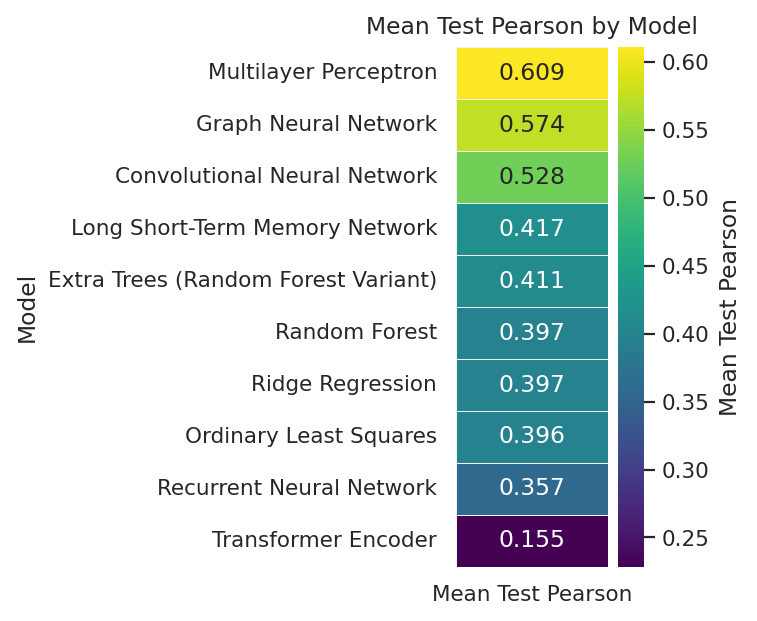

In [7]:
summary_reset = analysis_state["summary_reset"]
model_order = analysis_state["model_display_order"]
if "test_pearson_mean" not in summary_reset:
    print("Test Pearson summary unavailable; skipping heatmap.")
    fig_test_heatmap = None
else:
    ranked = summary_reset.sort_values("test_pearson_mean", ascending=False)
    best_per_model = ranked.drop_duplicates("model_id")
    heatmap_series = best_per_model.set_index("model_display")["test_pearson_mean"]
    heatmap_df = heatmap_series.reindex(model_order).dropna().to_frame(name="Mean Test Pearson")
    if heatmap_df.empty:
        print("No aggregated test Pearson values available; skipping heatmap.")
        fig_test_heatmap = None
    else:
        vmin, vmax = compute_heatmap_limits(heatmap_df.values)
        fig_height = max(4, 0.4 * len(heatmap_df))
        fig_test_heatmap, ax = plt.subplots(figsize=(4.5, fig_height))
        sns.heatmap(
            heatmap_df,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".3f",
            linewidths=0.4,
            linecolor="#f2f2f2",
            cbar_kws={"label": "Mean Test Pearson"},
            ax=ax,
        )
        ax.set_title("Mean Test Pearson by Model")
        ax.set_xlabel("")
        ax.set_ylabel("Model")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        sns.despine(fig_test_heatmap, left=True, bottom=True)
        plt.tight_layout()
register_figure(FIGURES, "test_pearson_heatmap_all_models", fig_test_heatmap)
if fig_test_heatmap is not None:
    display(fig_test_heatmap)
    plt.close(fig_test_heatmap)


### Optional Validation Heatmap

Displays the genes with the highest mean validation Pearson across all models (top 15 by default).


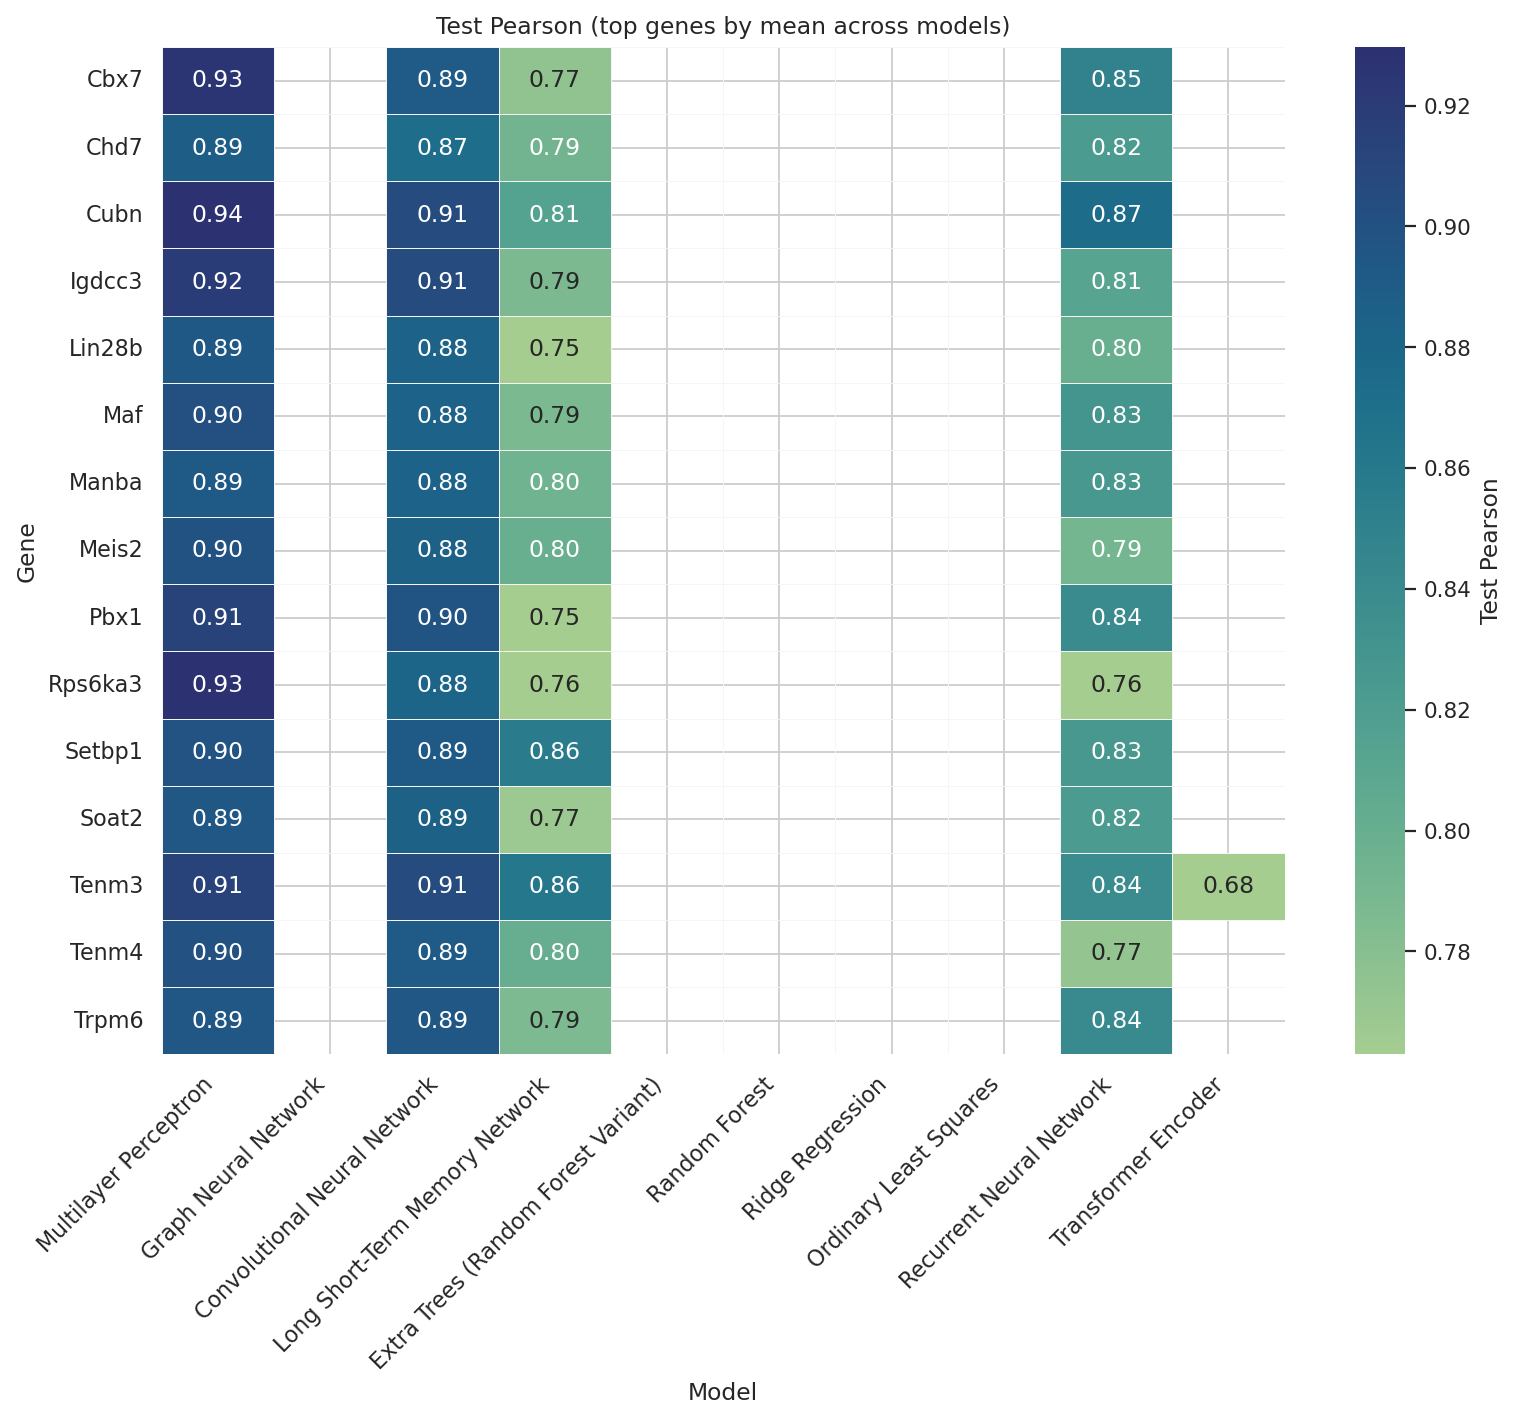

In [8]:
summary_reset = analysis_state["summary_reset"]
test_pivot = analysis_state.get("test_pearson_per_gene")
test_metrics = analysis_state["test_metrics"]
if test_pivot is None or test_pivot.empty:
    print("Test Pearson data unavailable; skipping heatmap.")
    fig_test_heatmap_top = None
else:
    top_test_genes = (
        test_metrics.groupby("gene")["pearson"].mean().sort_values(ascending=False).head(config.top_gene_count)
    )
    analysis_state["test_top_genes"] = top_test_genes.index.tolist()
    test_top_subset = test_pivot.loc[test_pivot.index.intersection(top_test_genes.index)]
    if test_top_subset.empty:
        print("Top-performing gene subset empty; skipping test heatmap.")
        fig_test_heatmap_top = None
    else:
        model_order = summary_reset[["model_display", "model_id"]].drop_duplicates("model_id")["model_display"].tolist()
        ordered_columns = [col for col in model_order if col in test_top_subset.columns]
        test_top_subset = test_top_subset.reindex(columns=ordered_columns)
        vmin, vmax = compute_heatmap_limits(
            test_top_subset.values, lower_percentile=10.0, upper_percentile=95.0
)
        fig_height_top = max(4, 0.6 * len(test_top_subset.index))
        fig_test_heatmap_top, ax = plt.subplots(figsize=(10, fig_height_top))
        sns.heatmap(
            test_top_subset,
            cmap="crest",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".2f",
            linewidths=0.3,
            linecolor="#f5f5f5",
            cbar_kws={"label": "Test Pearson"},
            ax=ax,
        )
        ax.set_title("Test Pearson (top genes by mean across models)")
        ax.set_xlabel("Model")
        ax.set_ylabel("Gene")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
        sns.despine(fig_test_heatmap_top, left=True, bottom=True)
        plt.tight_layout()
register_figure(FIGURES, "test_pearson_heatmap_top", fig_test_heatmap_top)
if fig_test_heatmap_top is not None:
    display(fig_test_heatmap_top)
    plt.close(fig_test_heatmap_top)

## 8. Test Distribution Profiles

Distributional views of per-gene Pearson correlations across models.


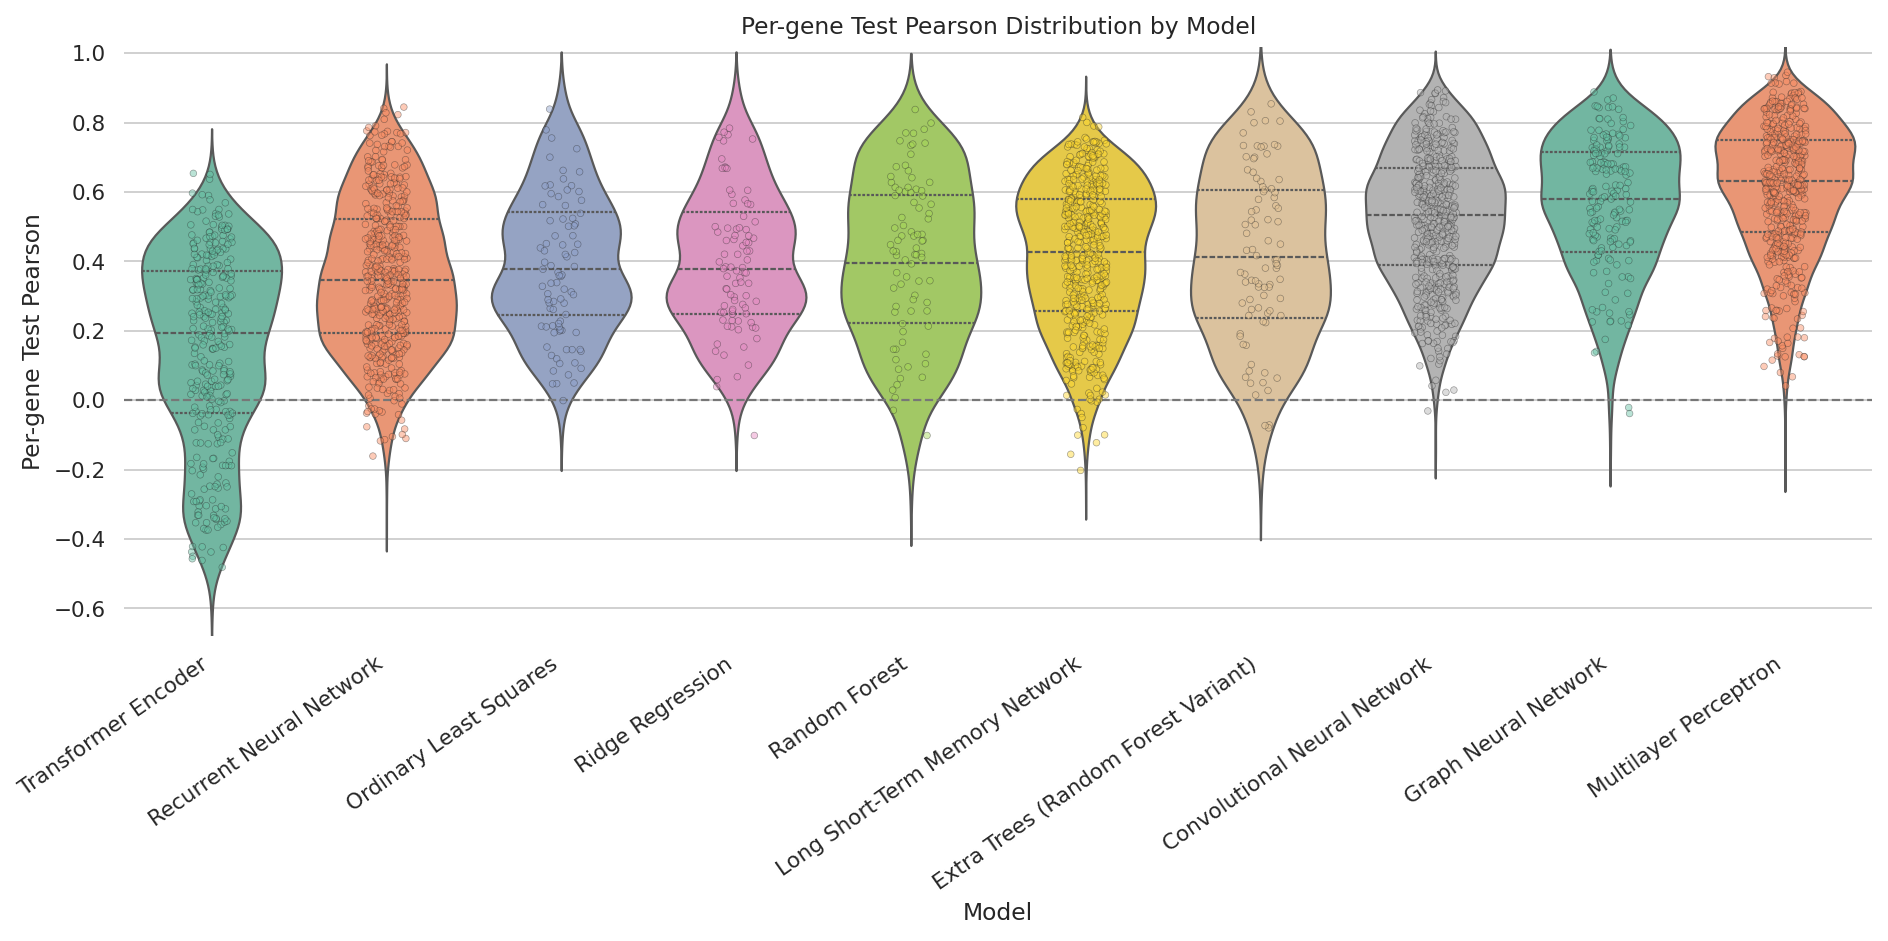

In [9]:
test_metrics = analysis_state["test_metrics"].copy()
summary_reset = analysis_state["summary_reset"]
model_display_order = analysis_state["model_display_order"]
if test_metrics.empty:
    print("Test metrics unavailable; skipping violin plot.")
    fig_violin = None
else:
    mean_by_model = summary_reset.groupby("model_display")["test_pearson_mean"].mean()
    mean_order_series = mean_by_model.sort_values(ascending=True)
    model_order = [model for model in mean_order_series.index if model in model_display_order]
    if not model_order:
        model_order = model_display_order
    violin_palette = sns.color_palette("Set2", n_colors=len(model_order))
    palette_map = dict(zip(model_order, violin_palette))
    fig_width = max(12, 0.8 * max(6, len(model_order)))
    fig_violin, ax = plt.subplots(figsize=(fig_width, 6))
    sns.violinplot(
        data=test_metrics,
        x="model_display",
        y="pearson",
        hue="model_display",
        order=model_order,
        hue_order=model_order,
        palette=palette_map,
        density_norm="width",
        inner="quartile",
        linewidth=1.0,
        ax=ax,
        legend=False,
    )
    if len(test_metrics) > 0:
        sample_size = min(len(test_metrics), 3000)
        jitter_sample = (
            test_metrics.sample(sample_size, random_state=config.random_seed)
            if len(test_metrics) > sample_size
            else test_metrics
        )
        sns.stripplot(
            data=jitter_sample,
            x="model_display",
            y="pearson",
            order=model_order,
            hue="model_display",
            hue_order=model_order,
            palette=palette_map,
            dodge=False,
            alpha=0.45,
            size=3.0,
            jitter=0.12,
            linewidth=0.3,
            edgecolor="#2b2b2b",
            marker="o",
            ax=ax,
            legend=False,
        )
    metric_min = test_metrics["pearson"].min()
    metric_max = test_metrics["pearson"].max()
    ymin = min(-0.5, metric_min - 0.05)
    ymax = max(1.0, metric_max + 0.05)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Model")
    ax.set_ylabel("Per-gene Test Pearson")
    ax.set_title("Per-gene Test Pearson Distribution by Model")
    ax.axhline(0.0, color="#777777", linestyle="--", linewidth=1)
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")
    sns.despine(fig_violin, left=True, bottom=True)
    plt.tight_layout()
register_figure(FIGURES, "test_pearson_violin", fig_violin)
if fig_violin is not None:
    display(fig_violin)
    plt.close(fig_violin)


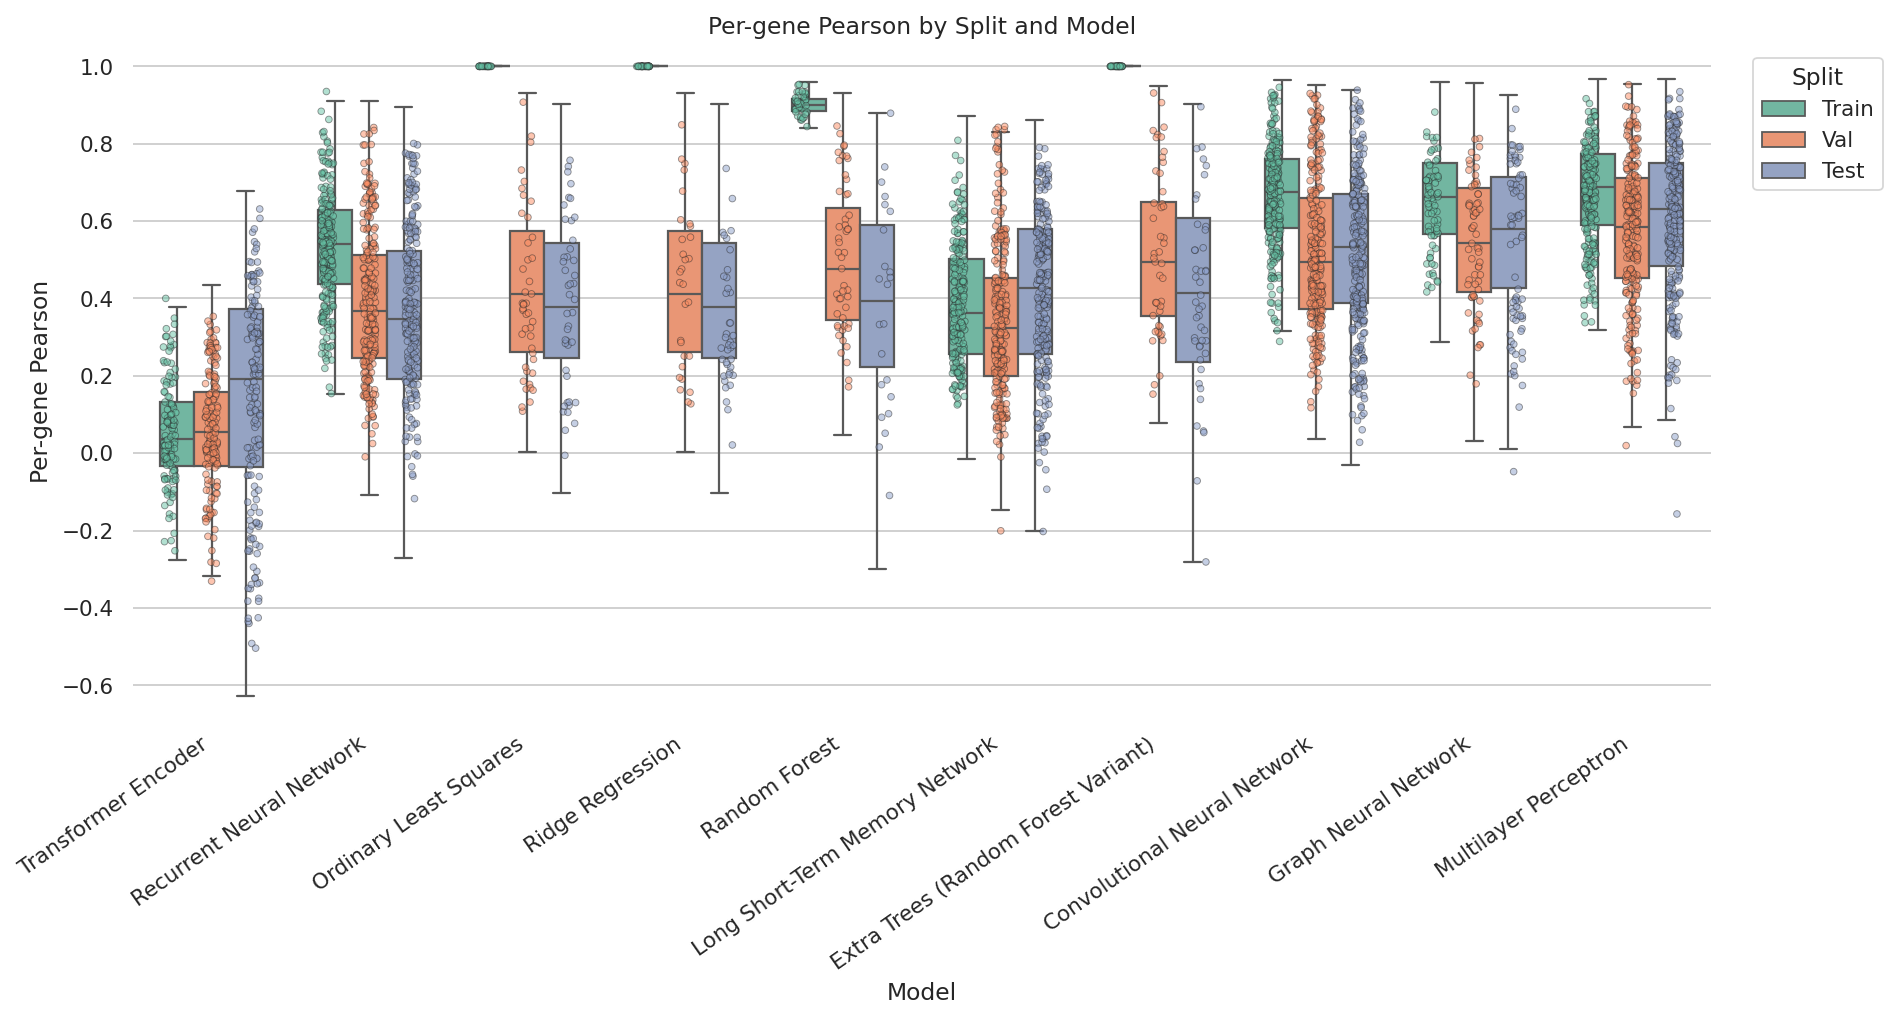

In [10]:
metrics_long = analysis_state["metrics_long"]
summary_reset = analysis_state["summary_reset"]
model_display_order = analysis_state["model_display_order"]
splits_of_interest = [config.train_split, config.val_split, config.primary_split]
subset = metrics_long[metrics_long["split"].isin(splits_of_interest)].copy()
if subset.empty or "pearson" not in subset:
    print("Pearson metrics unavailable across requested splits; skipping split comparison plot.")
    fig_split_compare = None
else:
    subset = subset[["model_display", "split", "pearson"]].dropna()
    split_labels = {
        config.train_split: "Train",
        config.val_split: "Val",
        config.primary_split: "Test",
    }
    subset["split_label"] = subset["split"].map(split_labels).fillna(subset["split"].str.title())
    test_means = summary_reset.groupby("model_display")["test_pearson_mean"].mean().sort_values()
    ordered_models = [model for model in test_means.index if model in subset["model_display"].unique()]
    if not ordered_models:
        ordered_models = model_display_order
    split_order = [split_labels[split] for split in splits_of_interest if split in split_labels]
    box_colors = sns.color_palette("Set2", n_colors=len(split_order))
    box_palette = dict(zip(split_order, box_colors))
    fig_width = max(12, 0.75 * max(6, len(ordered_models)))
    fig_split_compare, ax = plt.subplots(figsize=(fig_width, 6.5))
    sns.boxplot(
        data=subset,
        x="model_display",
        y="pearson",
        hue="split_label",
        order=ordered_models,
        hue_order=split_order,
        palette=box_palette,
        width=0.65,
        fliersize=0,
        ax=ax,
    )
    jitter_sample = subset.sample(min(len(subset), 4000), random_state=config.random_seed) if len(subset) > 4000 else subset
    sns.stripplot(
        data=jitter_sample,
        x="model_display",
        y="pearson",
        hue="split_label",
        order=ordered_models,
        hue_order=split_order,
        palette=box_palette,
        dodge=True,
        jitter=0.12,
        size=3.0,
        alpha=0.5,
        edgecolor="#2b2b2b",
        linewidth=0.4,
        marker="o",
        ax=ax,
        legend=False,
    )
    metric_min = subset["pearson"].min()
    metric_max = subset["pearson"].max()
    ymin = min(-0.5, metric_min - 0.05)
    ymax = max(1.0, metric_max + 0.05)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Model")
    ax.set_ylabel("Per-gene Pearson")
    ax.set_title("Per-gene Pearson by Split and Model")
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")
    ax.legend(title="Split", bbox_to_anchor=(1.02, 1), loc="upper left")
    sns.despine(fig_split_compare, left=True, bottom=True)
    fig_split_compare.tight_layout()
register_figure(FIGURES, "split_comparison_overview", fig_split_compare)
if fig_split_compare is not None:
    display(fig_split_compare)
    plt.close(fig_split_compare)


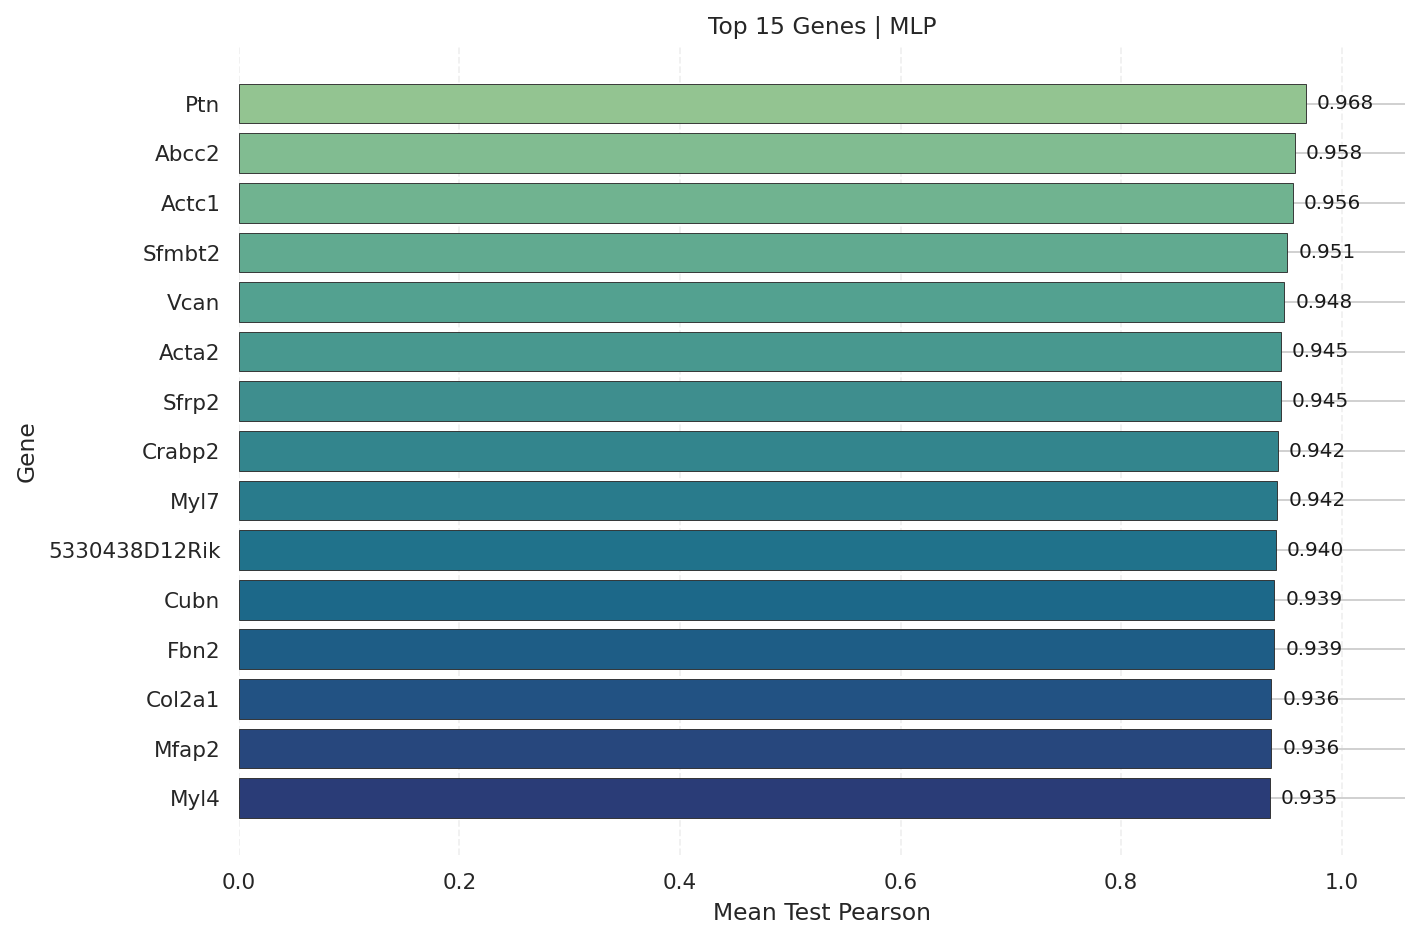

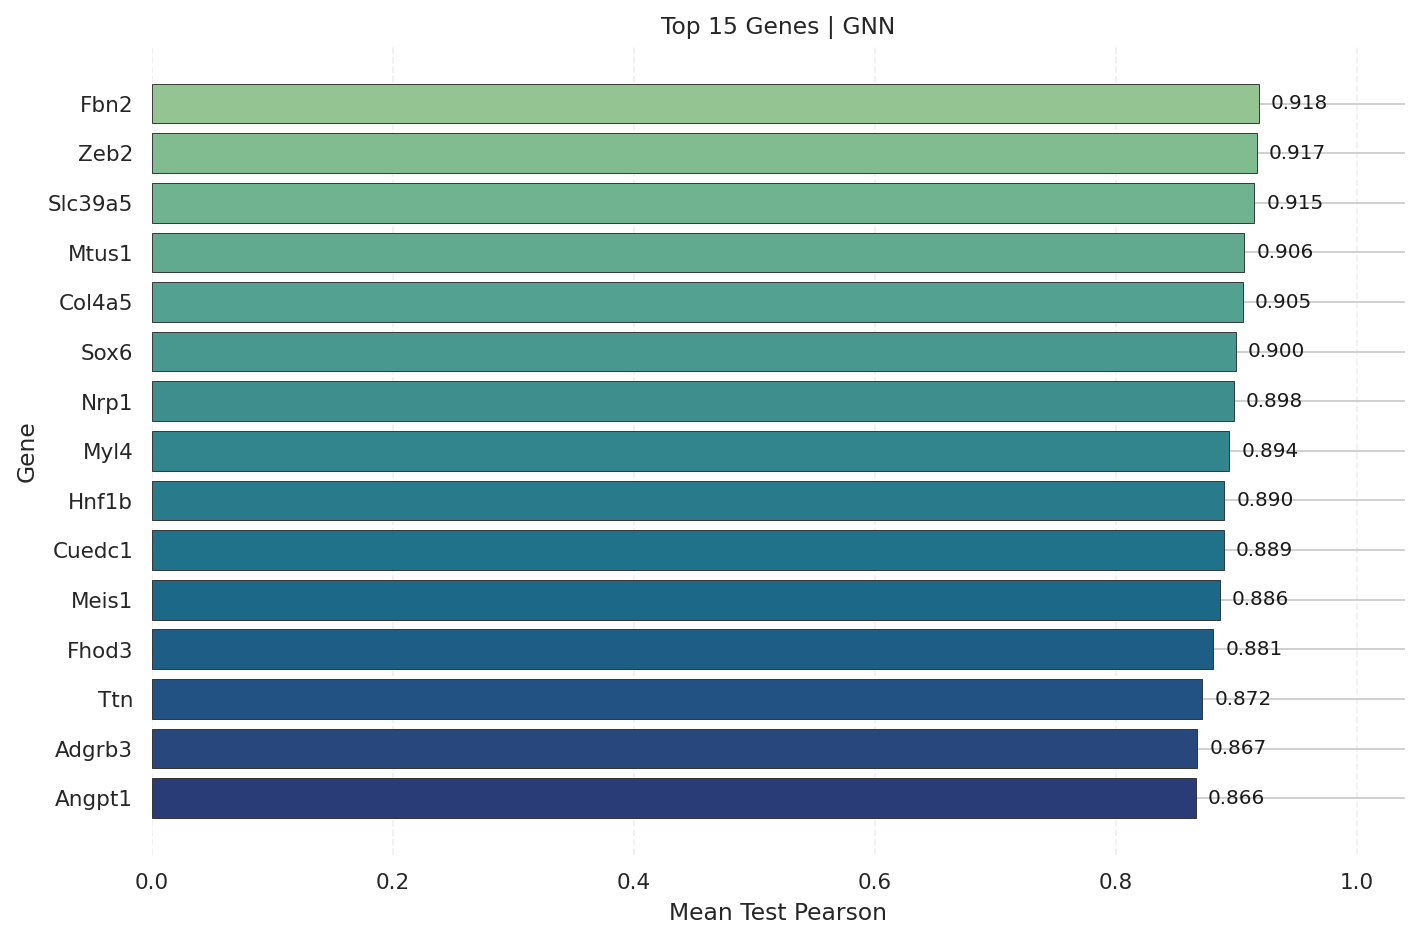

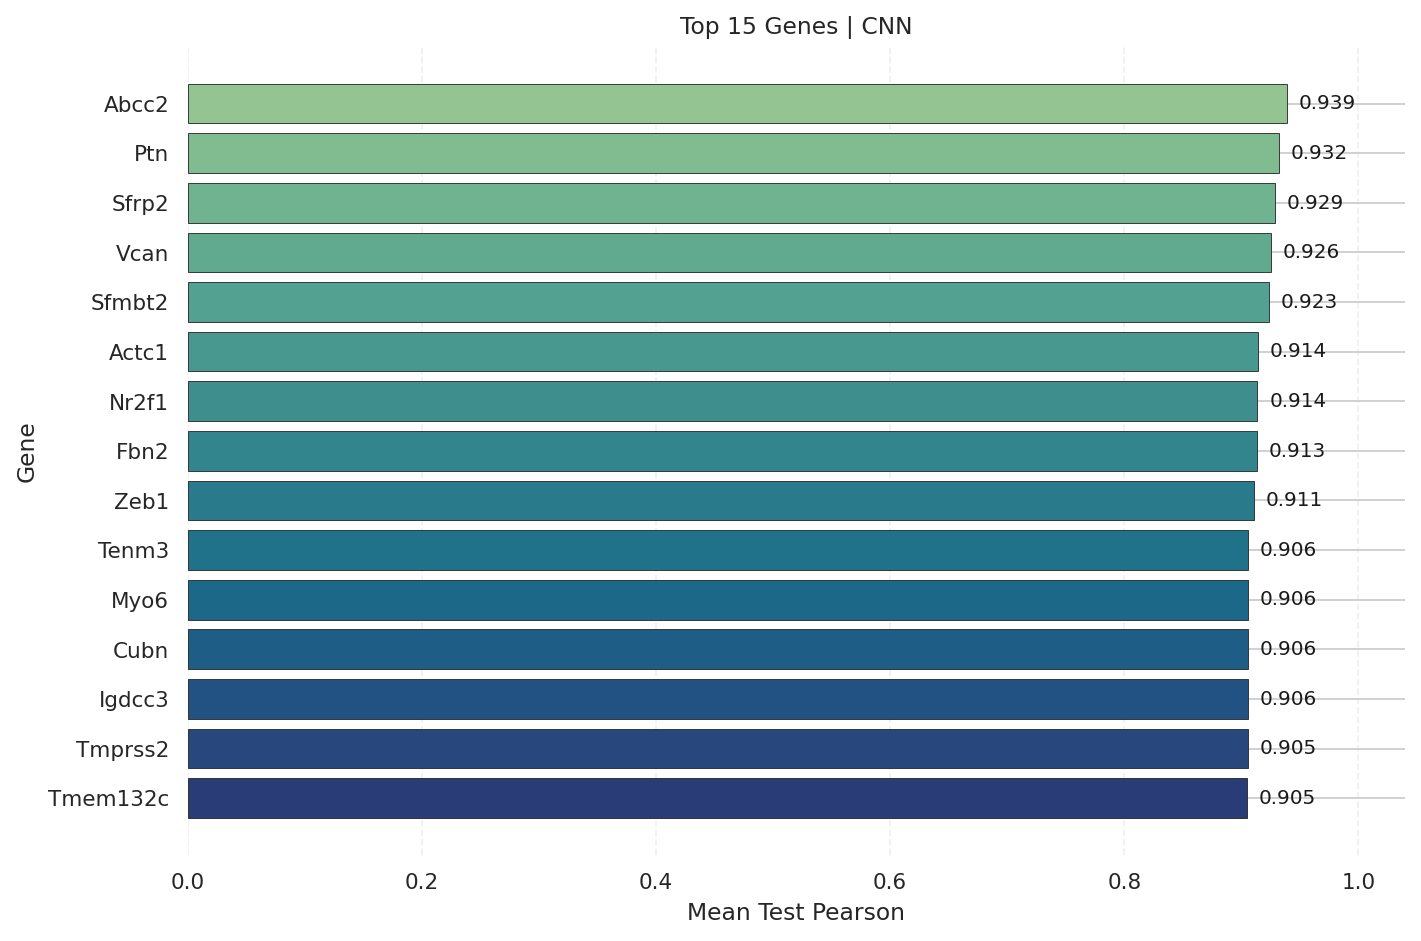

In [11]:
import re

test_metrics = analysis_state["test_metrics"]
summary_reset = analysis_state["summary_reset"]
short_map = analysis_state.get("model_short_name_map", MODEL_ID_TO_SHORT)

if test_metrics.empty:
    print("Test metrics unavailable; skipping top-gene visualisation.")
    analysis_state["top_gene_figure_keys"] = []
    fig_top_genes = None
else:
    if "test_pearson_mean" in summary_reset:
        ranked_models = summary_reset.sort_values("test_pearson_mean", ascending=False)
    else:
        ranked_models = summary_reset
    top_models = ranked_models.drop_duplicates("model_id").head(config.top_model_count)[["model_id", "model_display"]]
    gene_frames: list[pd.DataFrame] = []
    for row in top_models.itertuples(index=False):
        model_subset = test_metrics[test_metrics["model_id"] == row.model_id]
        if model_subset.empty:
            continue
        gene_stats = (
            model_subset.groupby("gene")["pearson"].agg(mean="mean", std="std", count="count").reset_index()
        )
        gene_stats.rename(
            columns={
                "mean": "mean_test_pearson",
                "std": "pearson_std",
                "count": "observation_count",
            },
            inplace=True,
        )
        short_name = short_map.get(row.model_id, to_short_name(row.model_display)) or row.model_display
        gene_stats["model_display_long"] = row.model_display
        gene_stats["model_display_short"] = short_name
        gene_frames.append(gene_stats)
    if not gene_frames:
        print("No genes available for top-model bar chart.")
        analysis_state["top_gene_figure_keys"] = []
        fig_top_genes = None
    else:
        top_gene_df = pd.concat(gene_frames, ignore_index=True)
        figure_keys: list[str] = []
        for long_name, short_name in (
            top_gene_df[["model_display_long", "model_display_short"]]
            .drop_duplicates()
            .itertuples(index=False, name=None)
        ):
            group = top_gene_df[top_gene_df["model_display_long"] == long_name]
            ordered = group.sort_values("mean_test_pearson", ascending=False).head(config.top_gene_count)
            if ordered.empty:
                continue
            fig, ax = plt.subplots(figsize=(9, 6))
            colors = sns.color_palette("crest", n_colors=len(ordered))
            bars = ax.barh(
                ordered["gene"],
                ordered["mean_test_pearson"],
                color=colors,
                edgecolor="#2b2b2b",
                linewidth=0.4,
            )
            ax.set_title(f"Top {config.top_gene_count} Genes | {short_name}")
            ax.set_xlabel("Mean Test Pearson")
            ax.set_ylabel("Gene")
            data_max = ordered["mean_test_pearson"].max()
            label_offset = max(0.01, data_max * 0.01)
            x_max = max(1.0, data_max + 0.05) + label_offset * 4
            ax.set_xlim(0, x_max)
            ax.grid(axis="x", linestyle="--", alpha=0.3)
            ax.invert_yaxis()
            for bar, mean_val in zip(bars, ordered["mean_test_pearson"]):
                y_pos = bar.get_y() + bar.get_height() / 2
                ax.text(
                    mean_val + label_offset,
                    y_pos,
                    f"{mean_val:.3f}",
                    ha="left",
                    va="center",
                    fontsize=9,
                    color="#1a1a1a",
                )
            sns.despine(ax=ax, left=True, bottom=True)
            plt.tight_layout()
            slug = re.sub(r"[^0-9a-zA-Z]+", "_", short_name.lower()).strip("_") or "model"
            key = f"top_genes_test_performance_{slug}"
            register_figure(FIGURES, key, fig)
            display(fig)
            plt.close(fig)
            figure_keys.append(key)
        analysis_state["top_gene_figure_keys"] = figure_keys
        fig_top_genes = None


## 9. Generalization Gap Overview

Summarise the difference between train and test mean Pearson per model to spot potential overfitting.


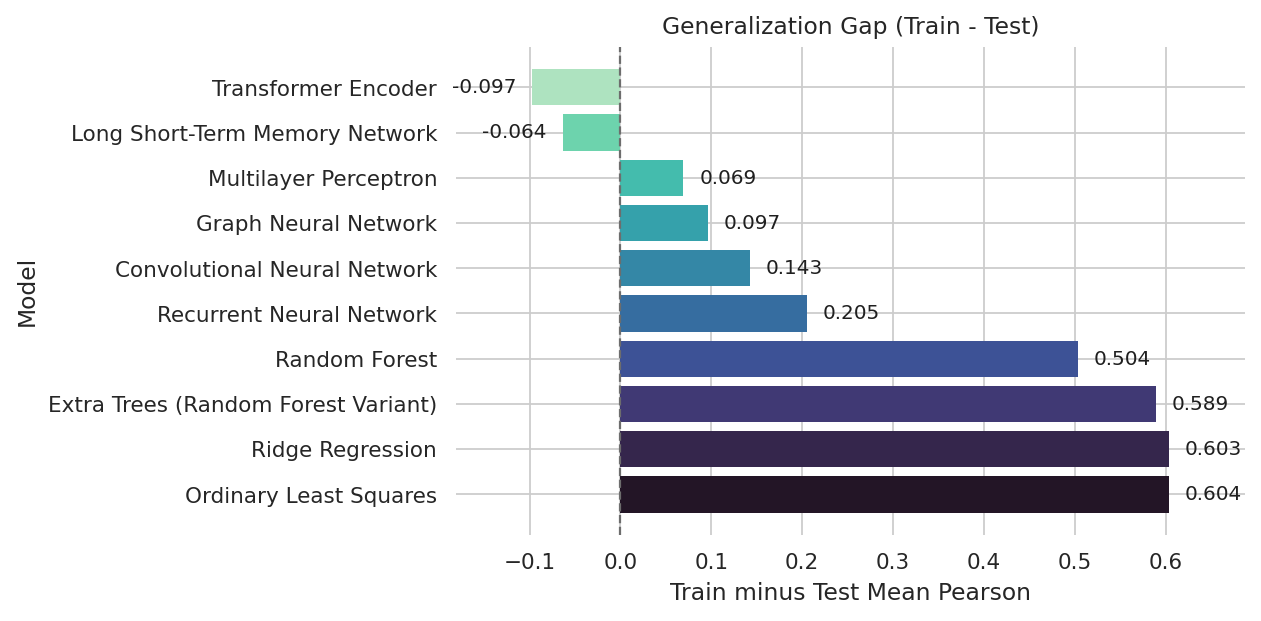

In [12]:
summary_reset = analysis_state["summary_reset"]
required_cols = {"train_pearson_mean", "test_pearson_mean"}
fig_generalization_gap = None
if not required_cols.issubset(summary_reset.columns):
    print("Train/test summary columns unavailable; skipping generalization gap plot.")
else:
    ranked = summary_reset.sort_values("test_pearson_mean", ascending=False)
    best_per_model = ranked.drop_duplicates("model_id")
    gap_df = best_per_model[["model_display", "train_pearson_mean", "test_pearson_mean"]].copy()
    gap_df["generalization_gap"] = gap_df["train_pearson_mean"] - gap_df["test_pearson_mean"]
    gap_df.sort_values("generalization_gap", ascending=False, inplace=True)
    fig_height = max(4, 0.35 * len(gap_df))
    fig_generalization_gap, ax = plt.subplots(figsize=(8, fig_height))
    colors = sns.color_palette("mako", n_colors=len(gap_df))
    bars = ax.barh(
        gap_df["model_display"],
        gap_df["generalization_gap"],
        color=colors,
        linewidth=0,
    )
    ax.axvline(0.0, color="#6d6d6d", linestyle="--", linewidth=1)
    gap_min = gap_df["generalization_gap"].min()
    gap_max = gap_df["generalization_gap"].max()
    span = max(0.01, gap_max - gap_min)
    margin = max(0.08, span * 0.12)
    xmin = min(gap_min - margin, gap_min - 0.02)
    xmin = min(xmin, -0.15)
    xmax = max(gap_max + margin, 0.15)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("Train minus Test Mean Pearson")
    ax.set_ylabel("Model")
    ax.set_title("Generalization Gap (Train - Test)")
    label_offset = (xmax - xmin) * 0.02
    for bar, value in zip(bars, gap_df["generalization_gap"]):
        y = bar.get_y() + bar.get_height() / 2
        if value >= 0:
            ax.text(value + label_offset, y, f"{value:.3f}", va="center", ha="left", fontsize=9, color="#1f1f1f")
        else:
            ax.text(value - label_offset, y, f"{value:.3f}", va="center", ha="right", fontsize=9, color="#1f1f1f")
    sns.despine(fig_generalization_gap, left=True, bottom=True)
    fig_generalization_gap.tight_layout()
register_figure(FIGURES, "generalization_gap", fig_generalization_gap)
if fig_generalization_gap is not None:
    display(fig_generalization_gap)
    plt.close(fig_generalization_gap)


## 10. Top-Model Diagnostics

Inline diagnostics for the top three models: scatter plots of test predictions and, when available, training loss history. Figures are not exported.


**Multilayer Perceptron** (run `grn_5000genes_k5_pg20_20251105_mlp`) — `scatter_test.png`

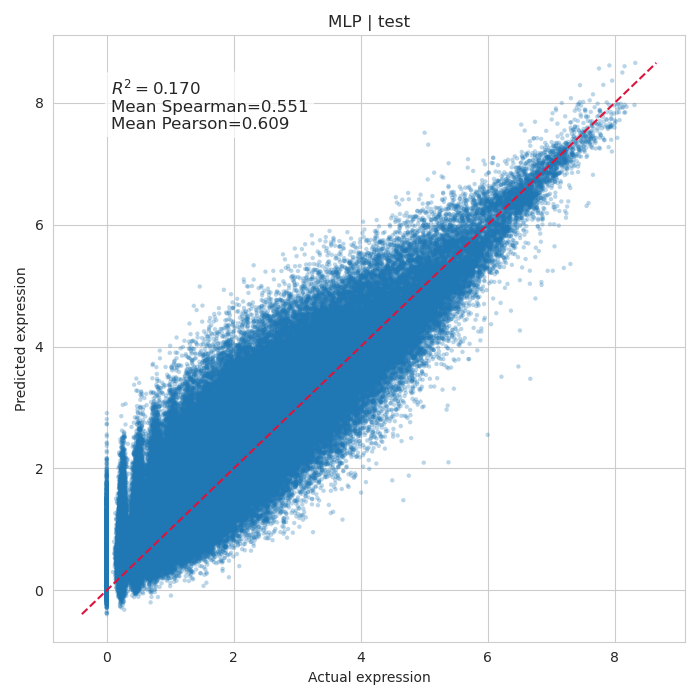

**Graph Neural Network** (run `grn_1000genes_k5_pg20_200kb_window_20251106_graph`) — `scatter_test.png`

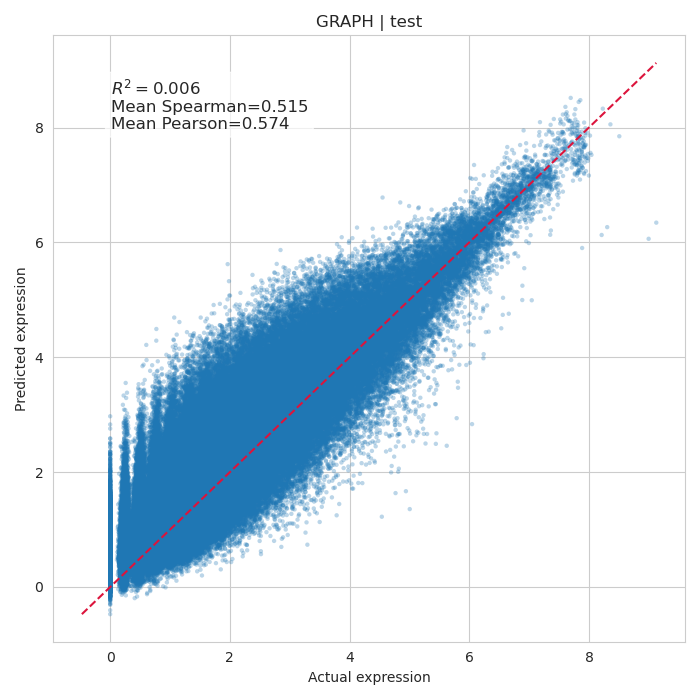

**Multilayer Perceptron** (run `grn_1000genes_k5_pg20_20251105_mlp`) — `scatter_test.png`

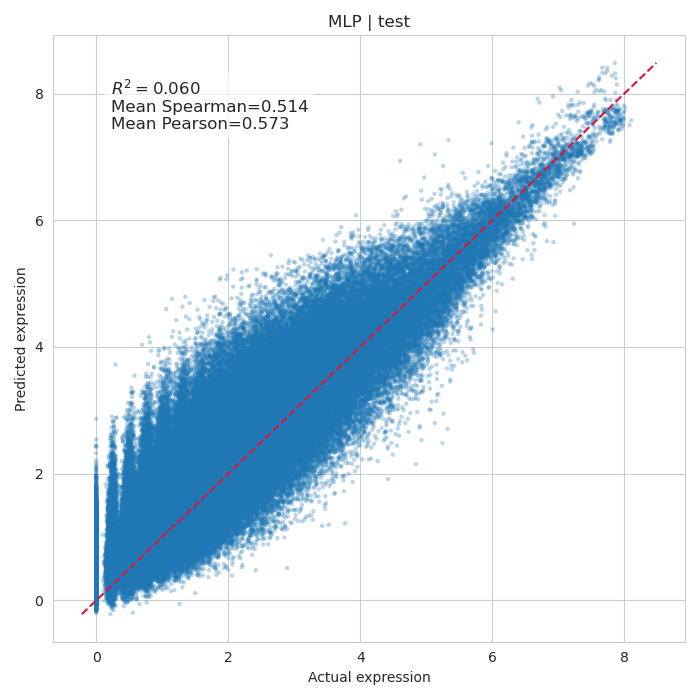

In [13]:
summary_reset = analysis_state["summary_reset"]
run_df = analysis_state["run_df"]

best_models = summary_reset.head(config.top_model_count).reset_index(drop=True)
if best_models.empty:
    print("No models available for scatter plot previews.")
else:
    missing_assets: list[str] = []
    for model_row in best_models.itertuples(index=False):
        run_rows = run_df[(run_df["model_id"] == model_row.model_id) & (run_df["run_name"] == model_row.run_name)]
        if run_rows.empty:
            missing_assets.append(
                f"Missing run directory metadata for {model_row.model_display} (run {model_row.run_name})."
            )
            continue
        row = run_rows.iloc[0]
        model_dir_raw = row["model_path"]
        model_dir = model_dir_raw if isinstance(model_dir_raw, Path) else Path(model_dir_raw)
        if not model_dir.exists():
            missing_assets.append(
                f"Model directory missing on disk for {model_row.model_display} (run {model_row.run_name})."
            )
            continue
        scatter_path = model_dir / "scatter_test.png"
        if scatter_path.exists():
            display(Markdown(
                f"**{model_row.model_display}** (run `{model_row.run_name}`) — `scatter_test.png`"
            ))
            display(Image(filename=str(scatter_path)))
        else:
            predictions_raw = row.get("predictions_path") if isinstance(row, pd.Series) else None
            predictions_path = None
            if predictions_raw:
                predictions_path = predictions_raw if isinstance(predictions_raw, Path) else Path(predictions_raw)
            if predictions_path and predictions_path.exists():
                missing_assets.append(
                    f"`scatter_test.png` not found for {model_row.model_display} (run {model_row.run_name}). "
                    f"Checked `{to_relative_path(model_dir, config.project_root)}`."
                )
            else:
                missing_assets.append(
                    f"No test predictions available for {model_row.model_display} (run {model_row.run_name}); skipping scatter preview."
                )
    if missing_assets:
        for message in missing_assets:
            print(message)

**Multilayer Perceptron** (run `grn_5000genes_k5_pg20_20251105_mlp`) — `training_history_loss.png`

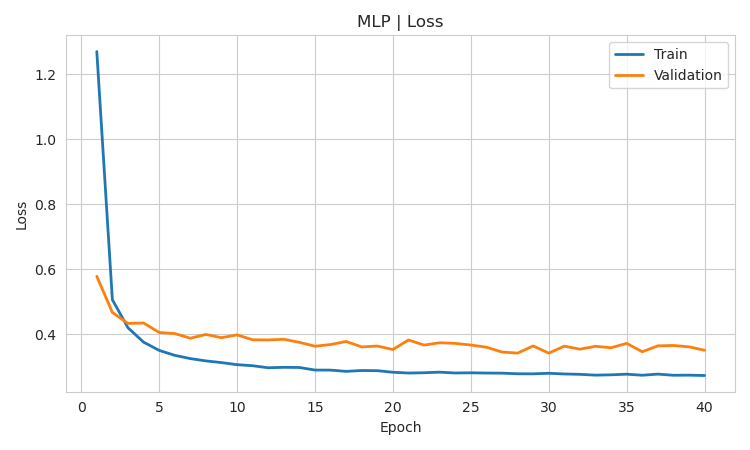

**Graph Neural Network** (run `grn_1000genes_k5_pg20_200kb_window_20251106_graph`) — `training_history_loss.png`

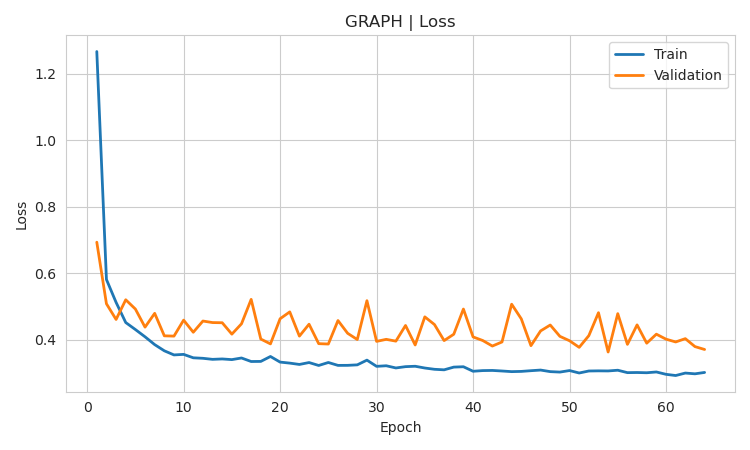

**Multilayer Perceptron** (run `grn_1000genes_k5_pg20_20251105_mlp`) — `training_history_loss.png`

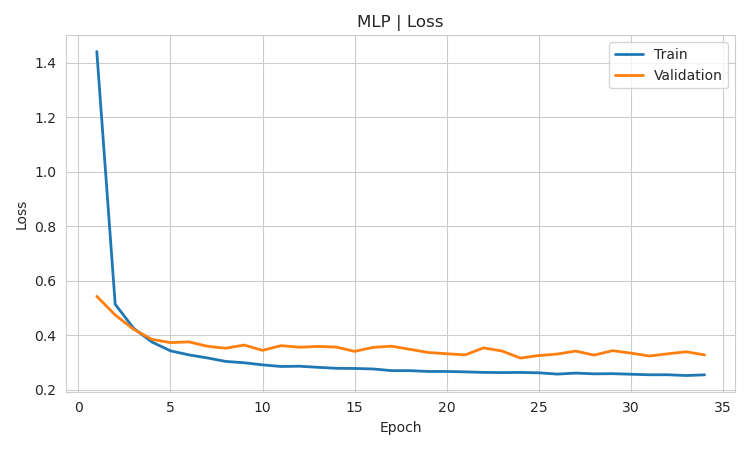

In [14]:
summary_reset = analysis_state["summary_reset"]
run_df = analysis_state["run_df"]

best_models = summary_reset.head(config.top_model_count).reset_index(drop=True)
if best_models.empty:
    print("Best models not identified; skipping training history previews.")
else:
    missing_assets: list[str] = []
    for model_row in best_models.itertuples(index=False):
        run_rows = run_df[(run_df["model_id"] == model_row.model_id) & (run_df["run_name"] == model_row.run_name)]
        if run_rows.empty:
            missing_assets.append(
                f"Missing run directory metadata for {model_row.model_display} (run {model_row.run_name})."
            )
            continue
        row = run_rows.iloc[0]
        model_dir_raw = row["model_path"]
        model_dir = model_dir_raw if isinstance(model_dir_raw, Path) else Path(model_dir_raw)
        if not model_dir.exists():
            missing_assets.append(
                f"Model directory missing on disk for {model_row.model_display} (run {model_row.run_name})."
            )
            continue
        history_candidates = [model_dir / "training_history_loss.png"]
        history_dir = model_dir / "histories"
        if history_dir.exists():
            history_candidates.extend(sorted(history_dir.glob("*_loss.png")))
        history_path = next((path for path in history_candidates if path.exists()), None)
        if history_path is not None:
            display(Markdown(
                f"**{model_row.model_display}** (run `{model_row.run_name}`) — `{history_path.name}`"
            ))
            display(Image(filename=str(history_path)))
        else:
            missing_assets.append(
                f"No training history plot available for {model_row.model_display} (run {model_row.run_name})."
            )
    if missing_assets:
        for message in missing_assets:
            print(message)

## 11. Export Artifacts

Persist figures and tables so the analysis can be shared or versioned outside the notebook session.


In [15]:
FIGURE_SAVE_PLAN: dict[str, list[Path]] = {
    "test_pearson_heatmap_all_models": [config.fig_dir / "test_pearson_heatmap_all_models.png"],
    "test_pearson_violin": [config.fig_dir / "test_pearson_violin.png"],
    "split_comparison_overview": [config.fig_dir / "split_comparison_overview.png"],
    "test_pearson_heatmap_top": [config.fig_dir / "test_pearson_heatmap_top_genes.png"],
    "generalization_gap": [config.fig_dir / "generalization_gap.png"],
}

top_gene_keys = analysis_state.get("top_gene_figure_keys", [])
for key in top_gene_keys:
    filename = f"{key}.png"
    FIGURE_SAVE_PLAN[key] = [config.fig_dir / filename]

TABLE_SAVE_PLAN: dict[str, list[Path]] = {
    "metrics_per_gene_master": [config.reports_dir / "metrics_per_gene_master.csv"],
    "summary_metrics_all_models": [config.reports_dir / "summary_metrics_all_models.csv"],
}

saved_figures: list[Path] = []
for key, targets in FIGURE_SAVE_PLAN.items():
    fig = FIGURES.get(key)
    if fig is None:
        print(f"Skipping figure '{key}' (not generated).")
        continue
    for target in targets:
        target.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(target, bbox_inches="tight")
        saved_figures.append(target)

saved_tables: list[Path] = []
for key, targets in TABLE_SAVE_PLAN.items():
    table = TABLES.get(key)
    if table is None or table.empty:
        print(f"Skipping table '{key}' (not generated or empty).")
        continue
    for target in targets:
        target.parent.mkdir(parents=True, exist_ok=True)
        table.to_csv(target, index=False)
        saved_tables.append(target)

print("Saved figures:")
for target in saved_figures:
    print(f" - {target}")

print("Saved tables:")
for target in saved_tables:
    print(f" - {target}")

if saved_figures:
    analysis_metadata["saved_figures"] = [to_relative_path(path, config.project_root) for path in saved_figures]


Saved figures:
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/test_pearson_heatmap_all_models.png
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/test_pearson_violin.png
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/split_comparison_overview.png
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/test_pearson_heatmap_top_genes.png
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/generalization_gap.png
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/top_genes_test_performance_mlp.png
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/top_genes_test_performance_gnn.png
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/figs/top_genes_test_performance_cnn.png
Saved tables:
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/reports/metrics_per_gene_master.csv
 - /gpfs/Home/tqw5435/uzun_rotation/analysis/reports/summary_metrics_all_models.csv


## 12. Session Metadata

Surface lightweight metadata so reruns can be traced back to the underlying assets.


In [16]:
generated_at = analysis_metadata.get("generated_at", "n/a")
results_root = analysis_metadata.get("results_root", "n/a")
run_count = analysis_metadata.get("run_count", "n/a")
model_count = analysis_metadata.get("model_count", "n/a")
best_display = analysis_metadata.get("best_model_display", "n/a")
best_id = analysis_metadata.get("best_model_id", "n/a")
best_run = analysis_metadata.get("best_run_name", "n/a")
report_markdown = f"""### Analysis Metadata
- Generated at: `{generated_at}`
- Results root: `{results_root}`
- Runs analysed: `{run_count}`
- Models analysed: `{model_count}`
- Best model: `{best_display}` (`{best_id}`)
- Source run: `{best_run}`"""
display(Markdown(report_markdown))

### Analysis Metadata
- Generated at: `2025-11-06T15:10:25`
- Results root: `output/results/grn_regression_cellwise`
- Runs analysed: `22`
- Models analysed: `22`
- Best model: `Multilayer Perceptron` (`mlp`)
- Source run: `grn_5000genes_k5_pg20_20251105_mlp`

## 13. Experimental Feature Importance Probing

Ad-hoc exploration cells for testing feature attribution ideas prior to promoting them into the main workflow. These cells are safe to skip when feature importance exports are unavailable.


In [17]:
best_details = analysis_state.get("best_model_details")
if best_details is None:
    summary_reset = analysis_state.get("summary_reset")
    run_df = analysis_state.get("run_df")
    if summary_reset is None or summary_reset.empty:
        raise RuntimeError("Best-model summary unavailable; please rerun Section 5 before using Section 13.")
    if run_df is None or run_df.empty:
        raise RuntimeError("Run metadata missing; rerun Section 4 before using Section 13.")
    leader = summary_reset.iloc[0]
    best_model_id = str(leader["model_id"])
    best_run_name = str(leader["run_name"])
    best_model_display = str(leader.get("model_display", best_model_id))
    match = run_df[(run_df["model_id"] == best_model_id) & (run_df["run_name"] == best_run_name)]
    if match.empty:
        raise RuntimeError(f"Unable to locate run folder for {best_model_display} (run {best_run_name}).")
    row = match.iloc[0]
    model_path_value = row.get("model_path")
    if isinstance(model_path_value, Path):
        best_model_dir = model_path_value.resolve()
    elif isinstance(model_path_value, str) and model_path_value:
        best_model_dir = Path(model_path_value).resolve()
    else:
        raise RuntimeError("Model directory not recorded for the leading model.")
    run_path_value = row.get("run_path")
    if isinstance(run_path_value, Path):
        best_run_dir = run_path_value.resolve()
    elif isinstance(run_path_value, str) and run_path_value:
        best_run_dir = Path(run_path_value).resolve()
    else:
        best_run_dir = best_model_dir.parent
    metrics_value = row.get("metrics_path")
    if isinstance(metrics_value, Path):
        metrics_path = metrics_value.resolve()
    elif isinstance(metrics_value, str) and metrics_value:
        metrics_path = Path(metrics_value).resolve()
    else:
        metrics_path = None
    preds_value = row.get("predictions_path")
    if isinstance(preds_value, Path):
        predictions_path = preds_value.resolve()
    elif isinstance(preds_value, str) and preds_value:
        predictions_path = Path(preds_value).resolve()
    else:
        predictions_path = None
    best_details = {
        "model_id": best_model_id,
        "model_display": best_model_display,
        "run_name": best_run_name,
        "model_dir": best_model_dir,
        "run_dir": best_run_dir,
        "metrics_path": metrics_path,
        "predictions_path": predictions_path,
    }
    analysis_state["best_model_details"] = best_details
relative_model_dir = to_relative_path(best_details["model_dir"], config.project_root)
summary_lines = [
    f"**Best model context**: `{best_details['model_display']}` (`{best_details['model_id']}`) from run `{best_details['run_name']}`",
    "",
    f"- Model directory: `{relative_model_dir}`",
]
if best_details.get("metrics_path") is not None:
    summary_lines.append(
        f"- Metrics file: `{to_relative_path(best_details['metrics_path'], config.project_root)}`"
)
if best_details.get("predictions_path") is not None:
    summary_lines.append(
        f"- Predictions file: `{to_relative_path(best_details['predictions_path'], config.project_root)}`"
)
display(Markdown("\n".join(summary_lines)))

**Best model context**: `Multilayer Perceptron` (`mlp`) from run `grn_5000genes_k5_pg20_20251105_mlp`

- Model directory: `output/results/grn_regression_cellwise/grn_5000genes_k5_pg20_20251105_mlp/models/mlp`
- Metrics file: `output/results/grn_regression_cellwise/grn_5000genes_k5_pg20_20251105_mlp/models/mlp/metrics_per_gene.csv`
- Predictions file: `output/results/grn_regression_cellwise/grn_5000genes_k5_pg20_20251105_mlp/models/mlp/predictions_raw.csv`

In [18]:
def _load_feature_importance_table(model_dir: Path) -> tuple[pd.DataFrame, Optional[Path]]:
    """Locate and standardise feature importances exported by the training pipeline."""
    patterns = [
        "feature_importance*.csv",
        "feature_importances*.csv",
        "feature_importance*.tsv",
        "feature_importances*.tsv",
        "feature_importance*.parquet",
        "feature_importances*.parquet",
    ]
    candidates: list[Path] = []
    for pattern in patterns:
        candidates.extend(model_dir.glob(pattern))
    if not candidates:
        for pattern in patterns:
            candidates.extend(model_dir.glob(f"**/{pattern}"))
    unique_candidates: list[Path] = []
    seen: set[Path] = set()
    for path in candidates:
        resolved = path.resolve()
        if resolved in seen:
            continue
        if resolved.suffix.lower() in {".png", ".jpg", ".jpeg"}:
            continue
        seen.add(resolved)
        unique_candidates.append(resolved)
    for candidate in sorted(unique_candidates):
        try:
            if candidate.suffix.lower() == ".parquet":
                df = pd.read_parquet(candidate)
            else:
                sep = "\t" if candidate.suffix.lower() in {".tsv", ".txt"} else ","
                df = pd.read_csv(candidate, sep=sep)
        except Exception as exc:
            print(f"Skipping {candidate.name}: failed to load ({exc})")
            continue
        if df.empty:
            continue
        lower_cols = {col.lower(): col for col in df.columns}
        feature_col = next((
            lower_cols[key]
            for key in ("feature", "feature_name", "name", "variable", "feature_id", "column")
            if key in lower_cols
        ), None)
        importance_col = next((
            lower_cols[key]
            for key in (
                "importance",
                "importance_score",
                "importance_mean",
                "score",
                "value",
                "gain",
                "weight",
            )
            if key in lower_cols
        ), None)
        if feature_col is None or importance_col is None:
            continue
        out = df.copy()
        out.rename(columns={feature_col: "feature", importance_col: "importance"}, inplace=True)
        out["feature"] = out["feature"].astype(str)
        out["importance"] = pd.to_numeric(out["importance"], errors="coerce")
        out = out.dropna(subset=["feature", "importance"])
        if out.empty:
            continue
        extra_cols = [col for col in out.columns if col not in {"feature", "importance"}]
        out = out[["feature", "importance", *extra_cols]]
        out.sort_values("importance", ascending=False, inplace=True)
        return out.reset_index(drop=True), candidate
    return pd.DataFrame(columns=["feature", "importance"]), None

importance_df, importance_path = _load_feature_importance_table(best_details["model_dir"])
analysis_state["best_model_feature_importances"] = importance_df
analysis_state["best_model_feature_importances_path"] = importance_path
if importance_df.empty:
    display(Markdown(
        "**Feature importances**: no compatible export found in the best-model directory. "
        "Upload or regenerate a table named `feature_importance*.csv|tsv|parquet` to enable the following cells."
    ))
else:
    note_lines = [
        "**Feature importances**: detected data source.",
    ]
    if importance_path is not None:
        note_lines.append(
            f"- Source file: `{to_relative_path(importance_path, config.project_root)}`"
)
        note_lines.append(f"- Rows: {len(importance_df):,}")
    display(Markdown("\n".join(note_lines)))
    display(importance_df.head(10))

**Feature importances**: no compatible export found in the best-model directory. Upload or regenerate a table named `feature_importance*.csv|tsv|parquet` to enable the following cells.

In [19]:
importance_df = analysis_state.get("best_model_feature_importances")
if importance_df is None or importance_df.empty:
    print("Feature importance data unavailable; skipping distribution plot.")
    fig_feature_importance_dist = None
else:
    importance_values = importance_df["importance"].astype(float)
    importance_values = importance_values[np.isfinite(importance_values)]
    if importance_values.empty:
        print("Importance column contains no finite values; skipping distribution plot.")
        fig_feature_importance_dist = None
    else:
        fig_feature_importance_dist, ax = plt.subplots(figsize=(6.5, 4.2))
        sns.histplot(importance_values, bins=40, kde=True, color="#377eb8", ax=ax)
        ax.set_title("Feature Importance Distribution | Best Model")
        ax.set_xlabel("Importance score")
        ax.set_ylabel("Feature count")
        sns.despine(fig_feature_importance_dist, left=True, bottom=True)
        plt.tight_layout()
        display(fig_feature_importance_dist)
        plt.close(fig_feature_importance_dist)

Feature importance data unavailable; skipping distribution plot.


In [20]:
importance_df = analysis_state.get("best_model_feature_importances")
distance_col = None
if importance_df is None or importance_df.empty:
    print("Feature importance data unavailable; skipping TSS distance analysis.")
else:
    candidate_cols = [
        "distance_to_tss_bp",
        "distance_to_tss",
        "distance_bp",
        "tss_distance_bp",
    ]
    for candidate in candidate_cols:
        if candidate in importance_df.columns:
            distance_col = candidate
            break
    if distance_col is None:
        bin_pattern = re.compile(r"bin_(-?\d+)_to_(-?\d+)")
        def _infer_distance(feature_name: str) -> Optional[float]:
            if not isinstance(feature_name, str):
                return None
            token = feature_name.split("|", 1)[-1]
            match = bin_pattern.search(token)
            if match:
                start_bp = float(match.group(1))
                end_bp = float(match.group(2))
                return 0.5 * (start_bp + end_bp)
            return None
        inferred = importance_df["feature"].map(_infer_distance)
        if inferred.notna().any():
            importance_df = importance_df.copy()
            importance_df["distance_to_tss_bp"] = inferred
            distance_col = "distance_to_tss_bp"
            analysis_state["best_model_feature_importances"] = importance_df
    if distance_col is None:
        print("Unable to derive feature-to-TSS distances from the available data; skipping scatter plot.")
    else:
        analysis_state["feature_importance_distance_column"] = distance_col
        valid = importance_df.dropna(subset=["importance", distance_col]).copy()
        if valid.empty:
            print("No features contained both importance scores and TSS distances.")
        else:
            valid["distance_kb"] = valid[distance_col].astype(float) / 1_000.0
            corr_value = valid[["distance_kb", "importance"]].corr(method="spearman").loc["distance_kb", "importance"]
            fig_distance, ax = plt.subplots(figsize=(7.5, 4.8))
            sns.scatterplot(
                data=valid,
                x="distance_kb",
                y="importance",
                s=32,
                alpha=0.6,
                edgecolor="none",
                color="#4daf4a",
                ax=ax,
            )
            sns.regplot(
                data=valid,
                x="distance_kb",
                y="importance",
                scatter=False,
                lowess=True,
                color="#984ea3",
                ax=ax,
            )
            ax.axvline(0.0, color="#999999", linestyle="--", linewidth=1)
            ax.set_xlabel("Distance to TSS (kb)")
            ax.set_ylabel("Feature importance")
            ax.set_title("Feature Importance vs. Distance to TSS | Best Model")
            ax.text(
                0.01,
                0.98,
                f"Spearman r = {corr_value:.3f}",
                transform=ax.transAxes,
                ha="left",
                va="top",
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.7, edgecolor="#cccccc"),
            )
            sns.despine(fig_distance, left=True, bottom=True)
            plt.tight_layout()
            display(fig_distance)
            plt.close(fig_distance)

Feature importance data unavailable; skipping TSS distance analysis.


In [21]:
importance_df = analysis_state.get("best_model_feature_importances")
if importance_df is None or importance_df.empty:
    print("Feature importance data unavailable; skipping ATAC peak view.")
else:
    feature_series = importance_df["feature"].astype(str)
    if "feature_type" in importance_df.columns:
        atac_mask = importance_df["feature_type"].astype(str).str.contains("atac|peak", case=False, na=False)
    else:
        atac_mask = feature_series.str.contains("peak", case=False, na=False)
    atac_df = importance_df[atac_mask].copy()
    if atac_df.empty:
        print("No ATAC-related feature names detected; adjust filtering logic if alternative naming is used.")
    else:
        top_atac = atac_df.nlargest(min(25, len(atac_df)), "importance")
        fig_atac, ax = plt.subplots(figsize=(9, max(4, 0.35 * len(top_atac))))
        sns.barplot(
            data=top_atac,
            x="importance",
            y="feature",
            palette="crest",
            ax=ax,
        )
        ax.set_title("Top ATAC Feature Importances | Best Model")
        ax.set_xlabel("Importance score")
        ax.set_ylabel("Feature")
        plt.tight_layout()
        display(fig_atac)
        plt.close(fig_atac)

Feature importance data unavailable; skipping ATAC peak view.


In [22]:
importance_df = analysis_state.get("best_model_feature_importances")
TOP_FEATURE_COUNT = 1_000
if importance_df is None or importance_df.empty:
    print("Feature importance data unavailable; unable to derive top features.")
else:
    top_n = min(TOP_FEATURE_COUNT, len(importance_df))
    top_features_df = importance_df.nlargest(top_n, "importance").reset_index(drop=True)
    analysis_state["best_model_top_features"] = top_features_df
    print(f"Captured top {top_n} features by importance for the best model.")
    display(top_features_df.head(10))

Feature importance data unavailable; unable to derive top features.


In [23]:
importance_df = analysis_state.get("best_model_feature_importances")
distance_col = analysis_state.get("feature_importance_distance_column")
distance_window_kb = 50
if importance_df is None or importance_df.empty:
    print("Feature importance data unavailable; cannot filter by TSS proximity.")
elif distance_col is None or distance_col not in importance_df.columns:
    print("No inferred distance-to-TSS column available; run the previous distance cell first or provide the column explicitly.")
else:
    window_mask = importance_df[distance_col].abs() <= distance_window_kb * 1_000
    subset_df = importance_df[window_mask].copy()
    if subset_df.empty:
        print(
            f"No features fall within ±{distance_window_kb} kb of the TSS according to column '{distance_col}'."
)
    else:
        subset_df.sort_values("importance", ascending=False, inplace=True)
        analysis_state["best_model_features_within_window"] = subset_df
        print(
            f"Identified {len(subset_df):,} features within ±{distance_window_kb} kb of the TSS (column '{distance_col}')."
)
        display(subset_df.head(10))

Feature importance data unavailable; cannot filter by TSS proximity.


In [24]:
best_details = analysis_state.get("best_model_details")
top_features_df = analysis_state.get("best_model_top_features")
subset_df = analysis_state.get("best_model_features_within_window")
importance_path = analysis_state.get("best_model_feature_importances_path")
distance_col = analysis_state.get("feature_importance_distance_column")
distance_window_kb = 50
if best_details is None:
    print("Best model context missing; rerun the first cell in Section 13.")
else:
    run_config_path = best_details["run_dir"] / "run_configuration.json"
    lines = [
        "**Execution scaffolding for reruns**",
        "",
        f"- Baseline config JSON: `{to_relative_path(run_config_path, config.project_root)}`",
        f"- Suggested CLI template: `python -m ml_grn_pipeline.cli --config-json {to_relative_path(run_config_path, config.project_root)} --models {best_details['model_id']} --run-name {best_details['run_name']}_experimental`",
    ]
    if importance_path is not None:
        lines.append(
            f"- Feature importance table: `{to_relative_path(importance_path, config.project_root)}`"
        )
    if top_features_df is not None and not top_features_df.empty:
        lines.append(
            "- Export `analysis_state[\"best_model_top_features\"]` to CSV/TSV and feed it into your data loader to mimic a top-1k feature run.",
        )
    else:
        lines.append("- Top-1k feature shortlist unavailable; populate feature importances first.")
    if subset_df is not None and not subset_df.empty and distance_col:
        lines.append(
            f"- Features within ±{distance_window_kb} kb (`{distance_col}`) cached in `analysis_state['best_model_features_within_window']`.",
        )
        lines.append(
            f"  Update `TrainingConfig.window_bp` to {distance_window_kb * 1_000:,} (±{distance_window_kb} kb) in the JSON before re-running.",
        )
    else:
        lines.append(
            f"- No cached subset for the ±{distance_window_kb} kb window; rerun the distance cell after providing TSS metadata.",
        )
    lines.append(
        "- Reminder: the notebook does not launch training jobs automatically; please run the CLI in a new terminal or submit via SLURM.",
    )
    display(Markdown("\n".join(lines)))

**Execution scaffolding for reruns**

- Baseline config JSON: `output/results/grn_regression_cellwise/grn_5000genes_k5_pg20_20251105_mlp/run_configuration.json`
- Suggested CLI template: `python -m ml_grn_pipeline.cli --config-json output/results/grn_regression_cellwise/grn_5000genes_k5_pg20_20251105_mlp/run_configuration.json --models mlp --run-name grn_5000genes_k5_pg20_20251105_mlp_experimental`
- Top-1k feature shortlist unavailable; populate feature importances first.
- No cached subset for the ±50 kb window; rerun the distance cell after providing TSS metadata.
- Reminder: the notebook does not launch training jobs automatically; please run the CLI in a new terminal or submit via SLURM.

## 11. Resource Usage Comparison

Compare peak memory usage across recent GRN model runs by parsing the SLURM cell-wise chunk logs.


/tmp/ipykernel_2677475/2312635438.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  resource_df["resolved_name"].fillna("Unknown model", inplace=True)
/tmp/ipykernel_2677475/2312635438.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

,Model label,Run name,Model ID,Accelerator,Peak RSS (GiB),Peak stage,Log file
28,Graph Neural Network,grn_1000genes_k5_pg20_200kb_window_20251106_graph,graph,GPU,711.42,pseudobulk:train:end,output/logs/grn_cellwise_chunk_gpu_3409821_6.out
26,Transformer Encoder,grn_1000genes_k5_pg20_200kb_window_20251106_tr...,transformer,GPU,711.38,pseudobulk:train:end,output/logs/grn_cellwise_chunk_gpu_3409821_4.out
27,Multilayer Perceptron,grn_1000genes_k5_pg20_200kb_window_20251106_mlp,mlp,GPU,618.84,pseudobulk:train:start,output/logs/grn_cellwise_chunk_gpu_3409821_5.out
25,Long Short-Term Memory Network,grn_1000genes_k5_pg20_200kb_window_20251106_lstm,lstm,GPU,618.81,pseudobulk:train:start,output/logs/grn_cellwise_chunk_gpu_3409821_3.out
2,svr,grn_1000genes_k5_pg20_20251105_svr,svr,CPU,344.77,train_multi_output:svr:fold5:end,output/logs/grn_cellwise_chunk_3409547_2.out
12,Convolutional Neural Network,grn_5000genes_k5_pg20_20251105_cnn,cnn,CPU,200.98,pseudobulk:train:end,output/logs/grn_cellwise_chunk_3409572_3.out
15,Transformer Encoder,grn_5000genes_k5_pg20_20251105_transformer,transformer,CPU,200.98,pseudobulk:train:end,output/logs/grn_cellwise_chunk_3409572_6.out
13,Recurrent Neural Network,grn_5000genes_k5_pg20_20251105_rnn,rnn,CPU,190.54,pseudobulk:train:end,output/logs/grn_cellwise_chunk_3409572_4.out
16,Multilayer Perceptron,grn_5000genes_k5_pg20_20251105_mlp,mlp,CPU,190.54,pseudobulk:train:end,output/logs/grn_cellwise_chunk_3409572_7.out
11,random_forest,grn_5000genes_k5_pg20_20251105_random_forest,random_forest,CPU,190.54,pseudobulk:train:end,output/logs/grn_cellwise_chunk_3409572_2.out


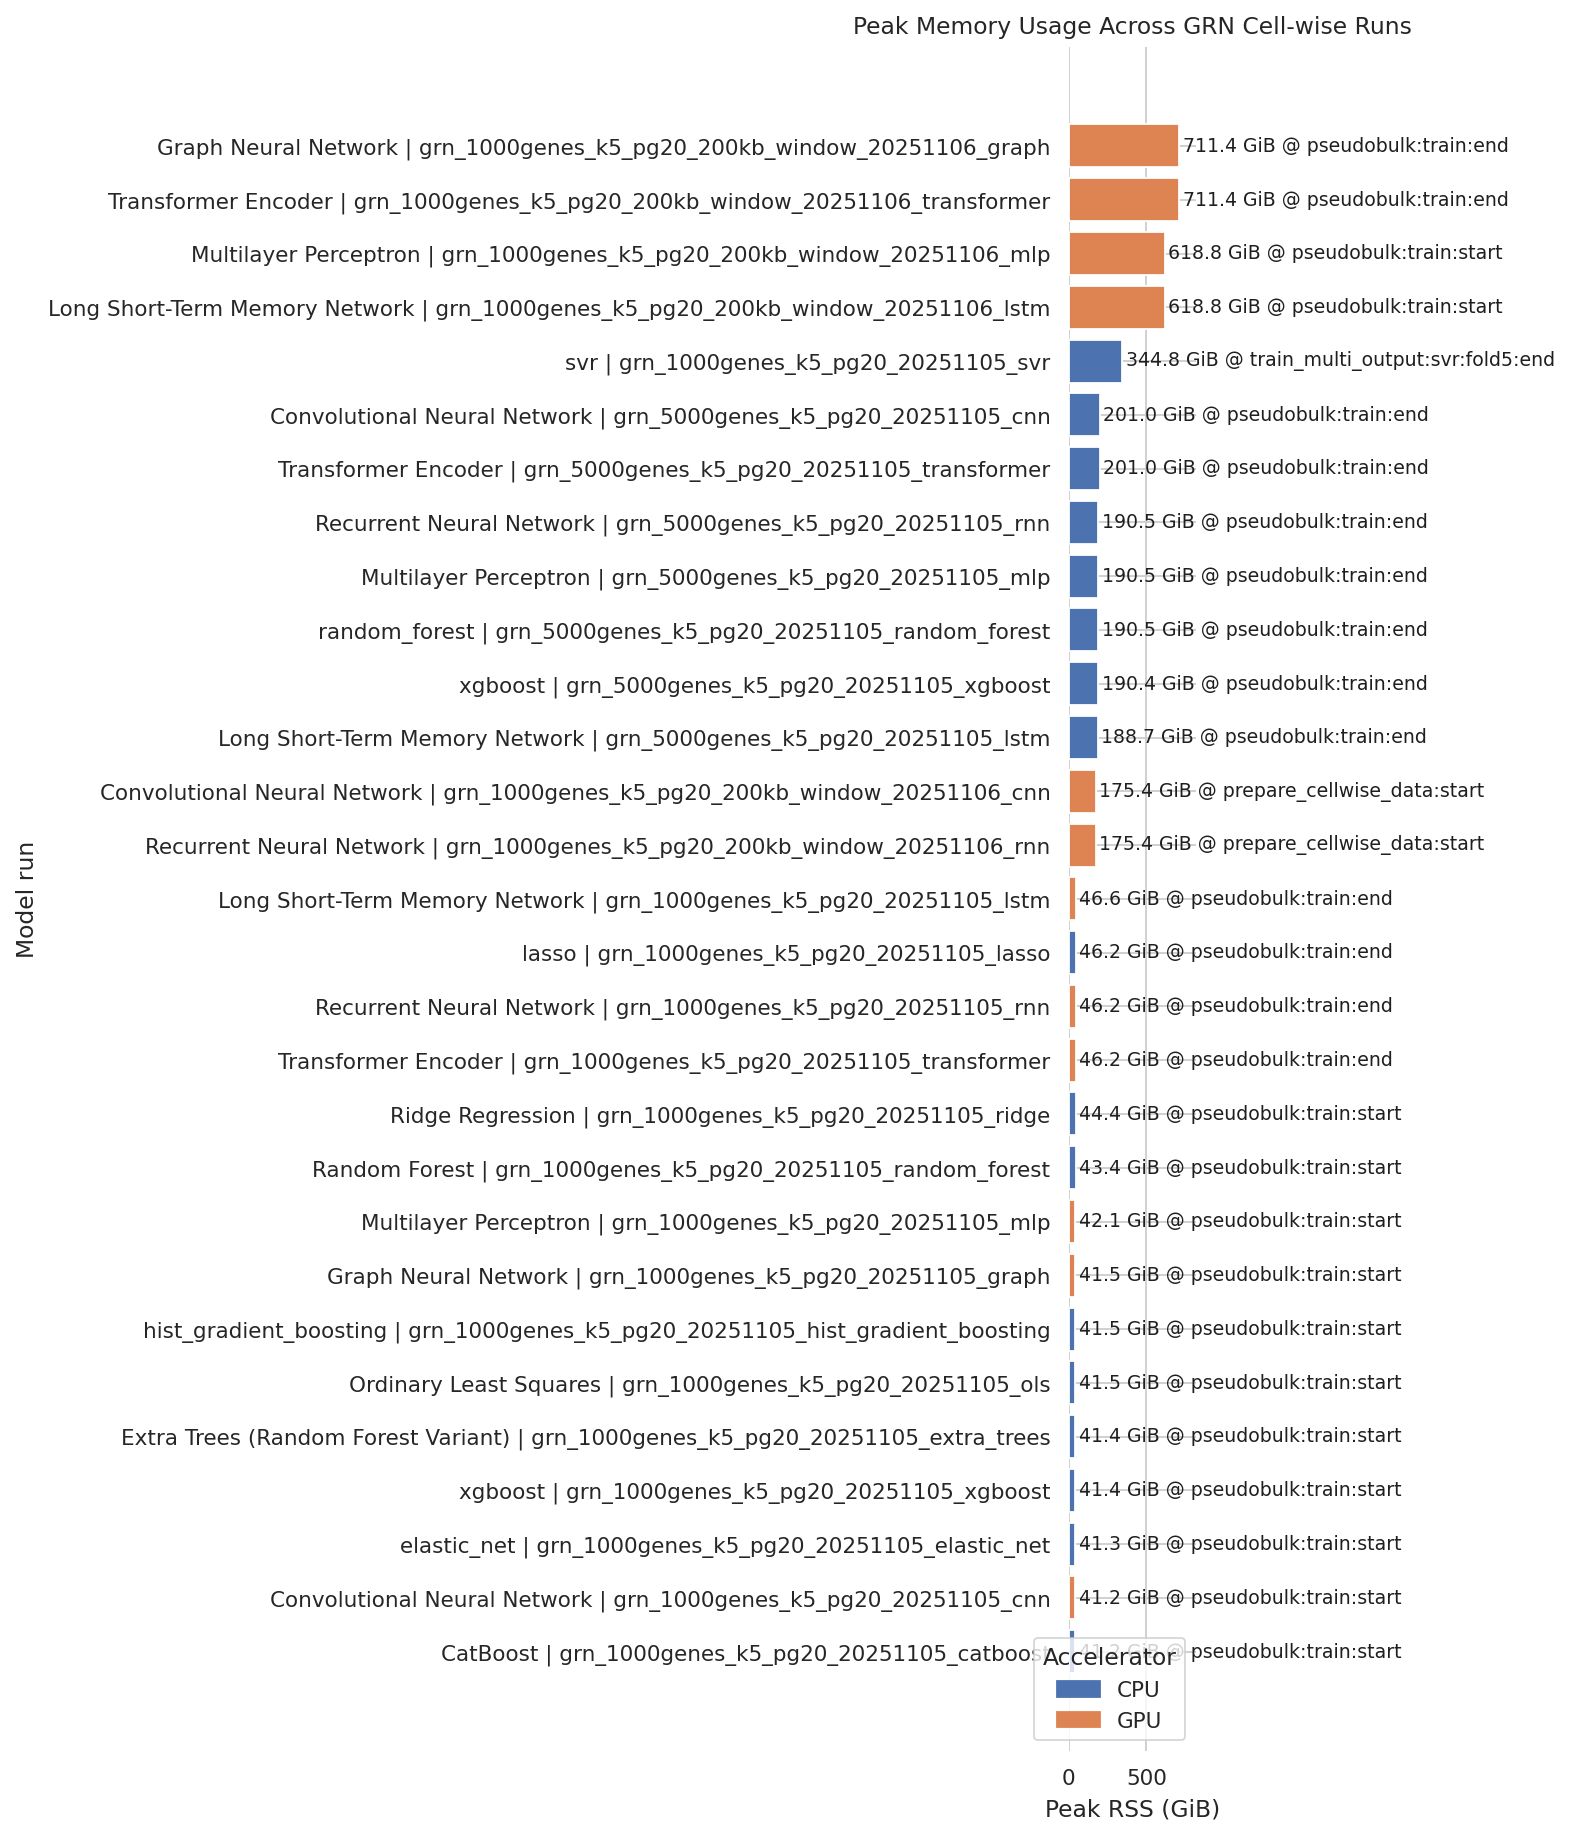

In [25]:
import re
from matplotlib.patches import Patch

# Parse SLURM logs to summarise peak memory usage per model run.
analysis_state = globals().get("analysis_state", {})
if not isinstance(analysis_state, dict):
    analysis_state = {}
    globals()["analysis_state"] = analysis_state

log_dir = config.project_root / "output" / "logs"
log_paths = sorted(log_dir.glob("grn_cellwise_chunk*.out"))
if not log_paths:
    print("No cell-wise chunk log files found under output/logs; skipping resource comparison.")
else:
    run_df = analysis_state.get("run_df")
    display_lookup: dict[str, str] = {}
    model_lookup: dict[str, str] = {}
    if isinstance(run_df, pd.DataFrame) and not run_df.empty:
        if "model_display" in run_df.columns and "run_name" in run_df.columns:
            display_lookup = dict(zip(run_df["run_name"], run_df["model_display"]))
        if "model_id" in run_df.columns and "run_name" in run_df.columns:
            model_lookup = dict(zip(run_df["run_name"], run_df["model_id"]))
    model_pattern = re.compile(r"model=([\w\-]+)")
    run_name_pattern = re.compile(r"run_name=([\w\-]+)")
    resource_pattern = re.compile(
        r"Resource snapshot\s*\|\s*(?P<context>[^|]+)\|\s*rss=(?P<rss>[0-9.]+)\s*GiB",
        re.IGNORECASE,
    )
    rows: list[dict[str, object]] = []
    for path in log_paths:
        try:
            with path.open("r", encoding="utf-8", errors="ignore") as fh:
                lines = fh.readlines()
        except Exception as exc:
            print(f"Skipping {path.name}: failed to read ({exc}).")
            continue
        model_id = None
        run_name = None
        peak_rss = None
        peak_stage = None
        for line in lines:
            if model_id is None:
                model_match = model_pattern.search(line)
                if model_match:
                    model_id = model_match.group(1)
            if run_name is None and "run_name=" in line:
                run_match = run_name_pattern.search(line)
                if run_match:
                    run_name = run_match.group(1)
            resource_match = resource_pattern.search(line)
            if resource_match:
                rss_val = float(resource_match.group("rss"))
                if peak_rss is None or rss_val > peak_rss:
                    peak_rss = rss_val
                    peak_stage = resource_match.group("context").strip()
        if model_id is None and run_name in model_lookup:
            model_id = model_lookup[run_name]
        log_relative = to_relative_path(path, config.project_root) if "to_relative_path" in globals() else str(path)
        rows.append(
            {
                "run_name": run_name,
                "model_id": model_id,
                "display_name": display_lookup.get(run_name),
                "peak_rss_gib": peak_rss,
                "peak_stage": peak_stage,
                "accelerator": "GPU" if "_gpu_" in path.name else "CPU",
                "log_file": log_relative,
                "log_stem": path.stem,
            }
        )
    resource_df = pd.DataFrame(rows)
    if resource_df.empty:
        print("No resource snapshots could be parsed from the available log files.")
    else:
        resource_df["peak_rss_gib"] = pd.to_numeric(resource_df["peak_rss_gib"], errors="coerce")
        resource_df["run_label"] = resource_df["run_name"].fillna(resource_df["log_stem"])
        resource_df["resolved_name"] = resource_df["display_name"]
        resource_df.loc[resource_df["resolved_name"].isna(), "resolved_name"] = resource_df.loc[resource_df["resolved_name"].isna(), "model_id"]
        resource_df.loc[resource_df["resolved_name"].isna(), "resolved_name"] = resource_df.loc[resource_df["resolved_name"].isna(), "run_label"]
        resource_df["resolved_name"].fillna("Unknown model", inplace=True)
        resource_df["run_label"].fillna("unknown_run", inplace=True)
        resource_df["label"] = resource_df["resolved_name"].astype(str) + " | " + resource_df["run_label"].astype(str)
        sorted_df = resource_df.sort_values("peak_rss_gib", ascending=False)
        analysis_state["resource_usage"] = sorted_df
        table = sorted_df.rename(
            columns={
                "resolved_name": "Model label",
                "run_label": "Run name",
                "model_id": "Model ID",
                "accelerator": "Accelerator",
                "peak_rss_gib": "Peak RSS (GiB)",
                "peak_stage": "Peak stage",
                "log_file": "Log file",
            }
)
        display(
            table[
                [
                    "Model label",
                    "Run name",
                    "Model ID",
                    "Accelerator",
                    "Peak RSS (GiB)",
                    "Peak stage",
                    "Log file",
                ]
            ]
        )
        valid = sorted_df.dropna(subset=["peak_rss_gib"]).copy()
        if valid.empty:
            print("Resource snapshots not yet present in the logs; rerun after the jobs emit resource metrics.")
        else:
            color_map = {"CPU": "#4C72B0", "GPU": "#DD8452"}
            colors = valid["accelerator"].map(color_map).fillna("#808080")
            fig_height = max(3.8, 0.4 * len(valid))
            fig_resource, ax = plt.subplots(figsize=(9, fig_height))
            bars = ax.barh(valid["label"], valid["peak_rss_gib"], color=colors)
            ax.invert_yaxis()
            ax.set_xlabel("Peak RSS (GiB)")
            ax.set_ylabel("Model run")
            ax.set_title("Peak Memory Usage Across GRN Cell-wise Runs")
            xmax = valid["peak_rss_gib"].max()
            if xmax <= 0:
                xmax = 1.0
            ax.set_xlim(0, xmax * 1.15)
            offset = max(1.0, xmax * 0.03)
            for bar, (_, row) in zip(bars, valid.iterrows()):
                stage_note = ""
                if isinstance(row["peak_stage"], str) and row["peak_stage"]:
                    stage_note = f" @ {row['peak_stage']}"
                ax.text(
                    bar.get_width() + offset,
                    bar.get_y() + bar.get_height() / 2,
                    f"{row['peak_rss_gib']:.1f} GiB{stage_note}",
                    va="center",
                    fontsize=8.5,
                    color="#1f1f1f",
                )
            legend_handles = [
                Patch(color=color_map[key], label=key)
                for key in sorted(valid["accelerator"].dropna().unique())
                if key in color_map
            ]
            if legend_handles:
                ax.legend(handles=legend_handles, title="Accelerator", loc="lower right")
            sns.despine(ax=ax, left=True, bottom=True)
            fig_resource.tight_layout()
            register_figure(FIGURES, "resource_usage_comparison", fig_resource)
            display(fig_resource)
            plt.close(fig_resource)

## Feature Importance Quick Guide
Merged from grn_feature_importance_guide.ipynb

## Workflow

1. Point `RUN_DIR` at the desired model output folder.
2. Load aggregate/per-gene summaries to inspect rankings.
3. View dataset-level overlays and per-gene panels saved by the pipeline.
4. (Optional) Regenerate custom panels or overlays on demand.


In [ ]:
from pathlib import Path
import pandas as pd
from IPython.display import display, Image

from src.ml_grn_pipeline.visualization import plot_per_gene_feature_panel, plot_cumulative_importance_overlay

In [ ]:
# Update this path to the run of interest
RUN_DIR = Path("output/results/grn_regression_cellwise/grn_100genes_k5_pg20_20251209_fi_mlp_mlp/models/mlp")
RUN_DIR

In [ ]:
aggregate_df = pd.read_csv(RUN_DIR / "feature_importances_mean.csv")
per_gene_df = pd.read_csv(RUN_DIR / "feature_importance_per_gene_summary.csv")
print(f'Aggregate features: {len(aggregate_df):,}')
print(f'Genes summarized: {len(per_gene_df):,}')
display(aggregate_df.head())
display(per_gene_df.head())

## Dataset-level overlays

Cumulative and scatter plots live in the model folder. Display them inline to sanity-check genome-wide patterns.


In [ ]:
overlay_path = RUN_DIR / "feature_importance_distance_overview.png"
scatter_path = RUN_DIR / "feature_importance_vs_tss_distance.png"
for label, path in (('Cumulative overlay', overlay_path), ('Scatter', scatter_path)):
    if path.exists():
        display(Image(filename=str(path)))
    else:
        print(f'No file found for {label}: {path}')

## Per-gene panels

The pipeline now saves PNGs under `per_gene_panels/`. List a few and display them inline.


In [ ]:
panel_dir = RUN_DIR / "per_gene_panels"
panel_paths = sorted(panel_dir.glob('*.png'))
print(f'Found {len(panel_paths)} per-gene panels')
for path in panel_paths[:4]:
    display(Image(filename=str(path)))

In [ ]:
def render_custom_panel(gene_name: str, top_n: int = 12):
    subset = aggregate_df[aggregate_df.get('gene_name') == gene_name]
    if subset.empty:
        raise ValueError(f'No features found for gene {gene_name}')
    out_path = RUN_DIR / "per_gene_panels" / f'custom_{gene_name}.png'
    plot_per_gene_feature_panel(subset, gene_name, out_path, top_n=top_n)
    display(Image(filename=str(out_path)))

example_gene = per_gene_df.sort_values('importance_mean_sum', ascending=False)['gene'].iloc[0]
render_custom_panel(example_gene)

In [ ]:
def recompute_overlay(max_distance_kb: float | None = None):
    df = aggregate_df.dropna(subset=['importance_mean', 'distance_to_tss_kb'])
    if max_distance_kb is not None:
        df = df[df['distance_to_tss_kb'].abs() <= max_distance_kb]
    out_path = RUN_DIR / "feature_importance_distance_overlay_custom.png"
    plot_cumulative_importance_overlay(df['importance_mean'], df['distance_to_tss_kb'], out_path, 'Custom FI cumulative profile')
    display(Image(filename=str(out_path)))

recompute_overlay(20)